In [608]:
# ===========================
#  CARGA DE LIBRERÍAS
# ===========================

# NumPy y pandas para manejo de datos
import numpy as np
import pandas as pd

# Librerías de visualización
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

# Estadística y regresión con Statsmodels
from statsmodels.api import OLS, add_constant

# Modelos lineales de Scikit-learn
from sklearn.linear_model import (
    LinearRegression,
    Ridge, Lasso, ElasticNet, LassoLars,
    RidgeCV, LassoCV, ElasticNetCV, LassoLarsCV
)

from group_lasso import GroupLasso

# Utilidades para entrenamiento y evaluación
from sklearn.model_selection import (
    train_test_split, KFold, GridSearchCV
)
from sklearn.metrics import (
    mean_squared_error, r2_score, make_scorer
)

# Preprocesamiento de datos
from sklearn.preprocessing import StandardScaler

# Pipeline y reducción de dimensionalidad
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

# Dataset de diabetes
from sklearn.datasets import load_diabetes

# Combinaciones útiles (por ejemplo, selección de variables)
from itertools import combinations

# Fijar semilla para reproducibilidad
import random
random.seed(1)


El **Diabetes Dataset** contiene información médica de pacientes y se utiliza para predecir la progresión de la enfermedad de la diabetes un año después de la recolección de los datos basales.

Tamaño del conjunto de datos:
- N° de muestras: 442 pacientes
- N° de predictores: 10 variables numéricas continuas

El conjunto de datos ha sido estandarizado (media 0, varianza 1). Los predictores son:
- Edad (age)
- Sexo (sex)
- Índice de masa corporal (BMI)
- Presión arterial media (bp)
- Seis medidas bioquímicas en sangre (s1 a s6)

In [609]:
# Cargar el dataset de Diabetes
diabetes = load_diabetes()

# Crear un DataFrame con los datos
df_diabetes = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)

# Agregar la columna de etiquetas (progresión de la diabetes)
df_diabetes['Progression'] = diabetes.target

# Mostrar las primeras filas
df_diabetes.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [610]:
np.isnan(df_diabetes['Progression']).sum()

0

### División del DataSet Diabetes

El conjunto de datos, generalmente, se divide en tres muestras no superpuestas: 

- **Muestra de entrenamiento** utilizada para entrenar el modelo. 
- **Muestra de validación** utilizada para validar y ajustar el modelo. 
- **Muestra de prueba** utilizada para probar la capacidad predictiva del modelo en nuevos datos. 

In [611]:
# Preparar los datos
y = np.array(df_diabetes['Progression'])
X = df_diabetes.drop('Progression', axis=1)  # Mantén X como un DataFrame


#Dividir en entrenamiento, validación y prueba
pct_val = 0.20
pct_test = 0.10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=pct_test)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=pct_val/(1-pct_test))

# Combinar entrenamiento y validación
X_combined = pd.concat([X_train, X_val], axis=0)
y_combined = np.concatenate([y_train, y_val])

### Elección del modelo óptimo

##### Cp de Mallows

In [612]:
# Modelo reducido: usaremos solo las primeras 4 variables como ejemplo
selected_features = ['age', 'sex', 'bmi', 'bp']

# Función para calcular Cp de Mallows
def Cp(X_train, y_train, selected_features):
    n = len(y_train)

    # Modelo completo para estimar sigma^2
    X_train_full = add_constant(X_train)
    model_full = OLS(y_train, X_train_full).fit()
    sigma2_hat = model_full.scale

    # Modelo reducido con las variables seleccionadas
    X_train_reduced = add_constant(X_train[selected_features])
    model_reduced = OLS(y_train, X_train_reduced).fit()
    rss_reduced = np.sum(model_reduced.resid ** 2)
    d_reduced = len(model_reduced.params)

    # Cálculo de Cp de Mallows
    Cp = (rss_reduced + 2 * d_reduced * sigma2_hat) / n
    return Cp

# Alternativa equivalente para calcular Cp (fórmula diferente)
def Cp_alternativa(X_train, y_train, selected_features):
    n = len(y_train)

    # Modelo completo para estimar sigma^2
    X_train_full = add_constant(X_train)
    model_full = OLS(y_train, X_train_full).fit()
    sigma2_hat = model_full.scale

    # Modelo reducido con las variables seleccionadas
    X_train_reduced = add_constant(X_train[selected_features])
    model_reduced = OLS(y_train, X_train_reduced).fit()
    rss_reduced = np.sum(model_reduced.resid ** 2)
    d_reduced = len(model_reduced.params)

    # Cálculo alternativo de Cp
    Cp_alt = (rss_reduced / sigma2_hat) - (n - 2 * d_reduced)
    return Cp_alt

# Resultados
print(f"Cp de Mallows del modelo reducido:             {Cp(X_train, y_train, selected_features):.4f}")
print(f"Cp_alternativa de Mallows del modelo reducido: {Cp_alternativa(X_train, y_train, selected_features):.4f}")


Cp de Mallows del modelo reducido:             3730.0033
Cp_alternativa de Mallows del modelo reducido: 86.2875


**add_constant()** agrega una columna de unos al inicio de la matriz de predictores. Esa columna representa el término independiente (intercepto) del modelo de regresión. Es necesario porque statsmodels.OLS no incluye automáticamente un intercepto, a diferencia de scikit-learn. Por eso hay que agregarlo manualmente si queremos que el modelo tenga un término constante. 

##### AIC, BIC y $R^{2}$ ajustado

Lo podemos calcular de manera manual utilizando la fórmula de aproximación para modelos lineales de AIC/BIC o utilizar statsmodels, ya que tiene incluido el calculo de AIC/BIC utilizando la verosimilitud del modelo reducido. 

In [613]:
def aic_manual(X_train, y_train, selected_features):
    X_train_red = add_constant(X_train[selected_features])

    # Ajustar modelo OLS
    model = OLS(y_train, X_train_red).fit()

    # --- Cálculos manuales ---
    n = len(y_train)                            # número de observaciones
    d = len(model.params)                       # número de parámetros
    rss = np.sum(model.resid ** 2)

    # AIC: AIC = (RSS + 2 * d * sigma^2) / n
    sigma2_hat = rss / (n - d)
    aic_manual = (rss + 2 * d * sigma2_hat) / n

    return aic_manual

def bic_manual(X_train, y_train, selected_features):
    X_train_red = add_constant(X_train[selected_features])

    # Ajustar modelo OLS
    model = OLS(y_train, X_train_red).fit()

    # --- Cálculos manuales ---
    n = len(y_train)                            # número de observaciones
    d = len(model.params)                       # número de parámetros
    rss = np.sum(model.resid ** 2)

    # BIC: BIC = (RSS + log(n) * d * sigma^2) / n
    sigma2_hat = rss / (n - d)
    bic_manual = (rss + np.log(n) * d * sigma2_hat) / n

    return bic_manual


def r2_adj_manual(X_train, y_train, selected_features):
    X_train_red = add_constant(X_train[selected_features])

    # Ajustar modelo OLS
    model = OLS(y_train, X_train_red).fit()

    # --- Cálculos manuales ---
    n = len(y_train)                            # número de observaciones
    d = len(model.params) - 1                     # número de parámetros, ya que model.params incluye el intercepto
    y_mean = np.mean(y_train)
    rss = np.sum(model.resid ** 2)
    tss = np.sum((y_train - y_mean)**2)

    # R² ajustado: R2_adj = 1 - (RSS / (n - d - 1)) / (TSS / (n - 1))
    r2_adj_manual = 1 - (rss / (n - d - 1)) / (tss / (n - 1))

    return r2_adj_manual


# --- Comparación con statsmodels ---
X_train_red = add_constant(X_train[selected_features])
model = OLS(y_train, X_train_red).fit()
aic = model.aic
bic = model.bic
r2_adj = model.rsquared_adj

# Mostrar resultados
print("--------- Cálculos Manuales ---------")
print(f"AIC manual:              {aic_manual(X_train, y_train, selected_features):.4f}")
print(f"BIC manual:              {bic_manual(X_train, y_train, selected_features):.4f}")
print(f"R² ajustado (manual):    {r2_adj_manual(X_train, y_train, selected_features):.4f}")

print("\n----------- Statsmodels -------------")
print(f"AIC (statsmodels):       {aic:.4f}")
print(f"BIC (statsmodels):       {bic:.4f}")
print(f"R² ajustado (stats):     {r2_adj:.4f}")


--------- Cálculos Manuales ---------
AIC manual:              3755.3825
BIC manual:              3979.1517
R² ajustado (manual):    0.3699

----------- Statsmodels -------------
AIC (statsmodels):       3409.1964
BIC (statsmodels):       3427.8469
R² ajustado (stats):     0.3699


### Validación y validación cruzada

##### Validación

In [614]:
# Función para calcular el error cuadrático medio (MSE) en un conjunto de validación
def validación(X_train, y_train, X_val, y_val, selected_features):
    # Ajustar modelo con las variables seleccionadas
    X_train_red = add_constant(X_train[selected_features])
    model = OLS(y_train, X_train_red).fit()
    
    # Preparar datos de validación
    X_val_reduced = add_constant(X_val[selected_features])
    
    # Predecir sobre el conjunto de validación
    y_val_pred = model.predict(X_val_reduced)
    
    # Calcular MSE
    MSE = mean_squared_error(y_val, y_val_pred)
    return MSE

# Mostrar resultado
print(f"MSE de validación: {validación(X_train, y_train, X_val, y_val, selected_features):.2f}")


MSE de validación: 3634.97


##### Validación Cruzada

In [615]:
# Función para realizar validación cruzada k-fold con OLS
def validacion_cruzada(X, y, selected_features, k):
    kf = KFold(n_splits=k, shuffle=True)  # Crea los pliegues con aleatorización
    mse_scores = []                       # Guarda el MSE de cada fold
    best_mse = float('inf')               # Inicializa el mejor MSE
    best_model_coefs = None               # Para guardar los coeficientes del mejor modelo

    for train_index, val_index in kf.split(X):
        # Separar conjuntos de entrenamiento y validación para este fold
        X_ktrain, X_kval = X.iloc[train_index], X.iloc[val_index]
        y_ktrain, y_kval = y[train_index], y[val_index]

        # Añadir la constante (intercepto) y seleccionar variables
        X_ktrain_red = add_constant(X_ktrain[selected_features])
        X_kval_red = add_constant(X_kval[selected_features])

        # Ajustar modelo OLS
        model_k = OLS(y_ktrain, X_ktrain_red).fit()

        # Predecir y calcular MSE en validación
        y_pred_k = model_k.predict(X_kval_red)
        mse_k = mean_squared_error(y_kval, y_pred_k)
        mse_scores.append(mse_k)

        # Si este modelo es mejor, guardarlo
        if mse_k < best_mse:
            best_mse = mse_k
            best_model_coefs = model_k.params

    return best_model_coefs, best_mse, mse_scores

k=5
vc=validacion_cruzada(X_combined, y_combined, selected_features, k=5)

print("\n===== Validación cruzada ({}-fold) =====".format(k))
print("MSE por fold:", np.round(vc[2], 2))
print(f"MSE medio (CV): {np.mean(vc[2]):.4f}")

print("\n===== Mejor modelo =====")
print(f"Mejor MSE: {vc[1]:.4f}")
print("Coeficientes del mejor modelo:")
print(vc[0])


===== Validación cruzada (5-fold) =====
MSE por fold: [3522.02 3754.81 3308.71 3548.19 4524.25]
MSE medio (CV): 3731.5959

===== Mejor modelo =====
Mejor MSE: 3308.7091
Coeficientes del mejor modelo:
const    152.989647
age       19.280838
sex      -15.930107
bmi      814.971068
bp       418.576787
dtype: float64


# Selección de subconjuntos

Aquí vamos a implementar los métodos que reducen el número de parámetros en un modelo restringuiendo el modelo a un subconjunto de los predictores. 

### Selección del mejor subconjunto

Basado en el **Algoritmo 2.1**

In [616]:
def mejor_subconjunto(X, y, criterio='AIC', X_val=None, y_val=None, k_cv=5, verbose=True):
    # p es el número de características (predictores) en el conjunto de datos
    p = X.shape[1]
    n = len(y)  # n es el número de observaciones
    predictores = X.columns  # Obtiene los nombres de las características (columnas de X)
    resultados_por_k = []  # Lista para almacenar los resultados de cada k

    # Para Cp: modelo completo
    X_full = add_constant(X)  # Agrega la constante (intercepto)
    modelo_full = OLS(y, X_full).fit()  # Ajusta el modelo completo usando OLS
    sigma2_hat = modelo_full.scale  # Estima sigma^2, el error cuadrático medio

    # Modelo nulo (sin predictores)
    modelo_nulo = OLS(y, np.ones((n, 1))).fit()  # Modelo que predice la media de y
    resultados_por_k.append({
        'k': 0,  # Modelo nulo tiene 0 predictores
        'modelo': modelo_nulo,
        'predictores': []
    })

    # Iterar sobre diferentes valores de k (número de predictores)
    for k in range(1, p + 1):
        mejor_r2 = -np.inf  # Inicializa el mejor R² en un valor muy negativo
        mejor_modelo_k = None  # Inicializa el mejor modelo
        mejor_comb = None  # Inicializa la mejor combinación de predictores

        # Genera todas las combinaciones posibles de k predictores
        for subset in combinations(predictores, k):
            X_k = add_constant(X[list(subset)])  # Agrega la constante a la combinación de predictores
            modelo = OLS(y, X_k).fit()  # Ajusta el modelo OLS con estos predictores
            r2 = modelo.rsquared  # Obtiene el R² del modelo

            # Si el R² es mejor que el anterior, actualiza los resultados
            if r2 > mejor_r2:
                mejor_r2 = r2
                mejor_modelo_k = modelo
                mejor_comb = subset

        # Almacena los resultados de este k en la lista
        resultados_por_k.append({
            'k': k,  # Número de predictores
            'modelo': mejor_modelo_k,  # Mejor modelo encontrado
            'predictores': mejor_comb,  # Mejor combinación de predictores
        })

    metricas = []  # Lista para almacenar las métricas de cada modelo
    mejores_modelos_cv = []  # Lista para almacenar los mejores modelos según validación cruzada

    # Calcula las métricas de cada modelo dependiendo del criterio elegido
    for res in resultados_por_k:
        modelo = res['modelo']

        # Selección según el criterio Cp
        if criterio == 'Cp':
            k = res['k']
            rss = np.sum(modelo.resid ** 2)  # Residual sum of squares (RSS)
            cp = (rss + 2 * k * sigma2_hat) / n  # Calcula Cp
            metricas.append(cp)

        # Selección según AIC
        elif criterio == 'AIC':
            metricas.append(modelo.aic)  # AIC del modelo ajustado

        # Selección según BIC
        elif criterio == 'BIC':
            metricas.append(modelo.bic)  # BIC del modelo ajustado

        # Selección según R² ajustado
        elif criterio == 'R2_adj':
            metricas.append(-modelo.rsquared_adj)  # R² ajustado (negado para minimización)

        # Selección según validación
        elif criterio == 'validacion':
            if X_val is None or y_val is None:
                raise ValueError("Debes proporcionar X_val e y_val para validación.")  # Validación debe tener datos
            X_val_red = add_constant(X_val[list(res['predictores'])])  # Datos de validación con los predictores seleccionados
            y_val_pred = modelo.predict(X_val_red)  # Predicciones en los datos de validación
            mse_val = mean_squared_error(y_val, y_val_pred)  # Error cuadrático medio (MSE) en validación
            metricas.append(mse_val)

        # Selección según validación cruzada
        elif criterio == 'cv':
            kf = KFold(n_splits=k_cv, shuffle=True)  # Dividir en k pliegues
            best_mse_k = float('inf')  # Inicializa el mejor MSE como infinito
            best_model_k = None  # Inicializa el mejor modelo

            # Realiza la validación cruzada
            for train_idx, val_idx in kf.split(X):
                X_train_k, X_val_k = X.iloc[train_idx], X.iloc[val_idx]  # Divide en entrenamiento y validación
                y_train_k, y_val_k = y[train_idx], y[val_idx]  # Divide las etiquetas
                X_train_red = add_constant(X_train_k[list(res['predictores'])])  # Datos de entrenamiento con predictores seleccionados
                modelo_k = OLS(y_train_k, X_train_red).fit()  # Ajusta el modelo en el conjunto de entrenamiento
                X_val_red = add_constant(X_val_k[list(res['predictores'])])  # Datos de validación
                y_pred_k = modelo_k.predict(X_val_red)  # Predicciones en validación
                mse_k = mean_squared_error(y_val_k, y_pred_k)  # Calcula el MSE

                # Si el MSE es mejor, actualiza el mejor modelo
                if mse_k < best_mse_k:
                    best_mse_k = mse_k
                    best_model_k = modelo_k

            # Almacena el mejor modelo encontrado en la validación cruzada
            metricas.append(best_mse_k)
            mejores_modelos_cv.append({
                'modelo': best_model_k,  # Mejor modelo encontrado
                'mse': best_mse_k,  # Mejor MSE
                'predictores': res['predictores']  # Combinación de predictores
            })

        else:
            raise ValueError("Criterio no reconocido.")  # Si el criterio no es reconocido

    # Selecciona el modelo con la mejor métrica
    idx_mejor = int(np.argmin(metricas))  # Encuentra el índice del mejor modelo (mínimo de las métricas)
    mejor_modelo = resultados_por_k[idx_mejor]  # Obtiene el mejor modelo

    # Si el criterio es validación cruzada, devuelve el mejor modelo y su MSE
    if criterio == 'cv':
        mejor_modelo_cv = mejores_modelos_cv[idx_mejor]
        if verbose:
            print(f"\n=== Mejor modelo según CV ===")
            print(f"  k = {mejor_modelo['k']}")  # Número de predictores
            print(f"  Predictores: {mejor_modelo['predictores']}")  # Combinación de predictores
            print(f"  Mejor MSE en CV: {mejor_modelo_cv['mse']:.4f}")  # MSE del mejor modelo
            print(mejor_modelo_cv['modelo'].summary())  # Resumen del modelo
        return mejor_modelo_cv, mejor_modelo_cv['mse']  # Devuelve el mejor modelo y su MSE

    # Si el criterio no es validación cruzada, devuelve el mejor modelo según el criterio seleccionado
    else:
        if verbose:
            print(f"\n========= Mejor modelo según {criterio} =========")
            print(f"  k = {mejor_modelo['k']}")  # Número de predictores
            print(f"  Predictores: {mejor_modelo['predictores']}")  # Combinación de predictores
            print(f"  Métrica ({criterio}): {metricas[idx_mejor]:.4f}")  # Métrica del mejor modelo
            print(mejor_modelo['modelo'].summary())  # Resumen del modelo
        return mejor_modelo, metricas[idx_mejor]  # Devuelve el mejor modelo y su métrica


In [617]:
# Usar Cp:
modelo_cp, valor_cp = mejor_subconjunto(X_train, y_train, criterio='Cp', verbose=True)


========= Mejor modelo según Cp =========
  k = 5
  Predictores: ('sex', 'bmi', 'bp', 's3', 's5')
  Métrica (Cp): 2942.3617
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     63.59
Date:                Thu, 15 May 2025   Prob (F-statistic):           3.60e-45
Time:                        10:53:56   Log-Likelihood:                -1662.0
No. Observations:                 308   AIC:                             3336.
Df Residuals:                     302   BIC:                             3358.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------

In [618]:
# Usar AIC:
modelo_aic, valor_aic = mejor_subconjunto(X_train, y_train, criterio='AIC', verbose=True)


========= Mejor modelo según AIC =========
  k = 5
  Predictores: ('sex', 'bmi', 'bp', 's3', 's5')
  Métrica (AIC): 3335.9869
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     63.59
Date:                Thu, 15 May 2025   Prob (F-statistic):           3.60e-45
Time:                        10:53:59   Log-Likelihood:                -1662.0
No. Observations:                 308   AIC:                             3336.
Df Residuals:                     302   BIC:                             3358.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----

In [619]:
# Usar BIC:
modelo_bic, valor_bic = mejor_subconjunto(X_train, y_train, criterio='BIC', verbose=True)


========= Mejor modelo según BIC =========
  k = 4
  Predictores: ('bmi', 'bp', 's3', 's5')
  Métrica (BIC): 3358.2309
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     76.95
Date:                Thu, 15 May 2025   Prob (F-statistic):           5.82e-45
Time:                        10:54:02   Log-Likelihood:                -1664.8
No. Observations:                 308   AIC:                             3340.
Df Residuals:                     303   BIC:                             3358.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

In [620]:
# Usar R2_adj:
modelo_R2_adj, valor_R2_adj = mejor_subconjunto(X_train, y_train, criterio='R2_adj', verbose=True)


========= Mejor modelo según R2_adj =========
  k = 7
  Predictores: ('sex', 'bmi', 'bp', 's1', 's3', 's5', 's6')
  Métrica (R2_adj): -0.5070
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.09
Date:                Thu, 15 May 2025   Prob (F-statistic):           4.52e-44
Time:                        10:54:05   Log-Likelihood:                -1660.3
No. Observations:                 308   AIC:                             3337.
Df Residuals:                     300   BIC:                             3366.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025 

In [621]:
# Usar validación (debe tener los datos de validación):
modelo_val, mse_val = mejor_subconjunto(X_train, y_train, criterio='validacion', X_val=X_val, y_val=y_val, verbose=True)


========= Mejor modelo según validacion =========
  k = 8
  Predictores: ('sex', 'bmi', 'bp', 's1', 's2', 's4', 's5', 's6')
  Métrica (validacion): 3153.6309
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     40.34
Date:                Thu, 15 May 2025   Prob (F-statistic):           2.45e-43
Time:                        10:54:09   Log-Likelihood:                -1660.0
No. Observations:                 308   AIC:                             3338.
Df Residuals:                     299   BIC:                             3372.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>

In [622]:
# Usar validación cruzada con k=5:
modelo_cv, mse_cv = mejor_subconjunto(X_combined, y_combined, criterio='cv', k_cv=5, verbose=True)


=== Mejor modelo según CV ===
  k = 9
  Predictores: ('age', 'sex', 'bmi', 'bp', 's1', 's2', 's4', 's5', 's6')
  Mejor MSE en CV: 2263.8651
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     34.65
Date:                Thu, 15 May 2025   Prob (F-statistic):           6.30e-42
Time:                        10:54:13   Log-Likelihood:                -1726.1
No. Observations:                 318   AIC:                             3472.
Df Residuals:                     308   BIC:                             3510.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025   

FIGURA 6.1

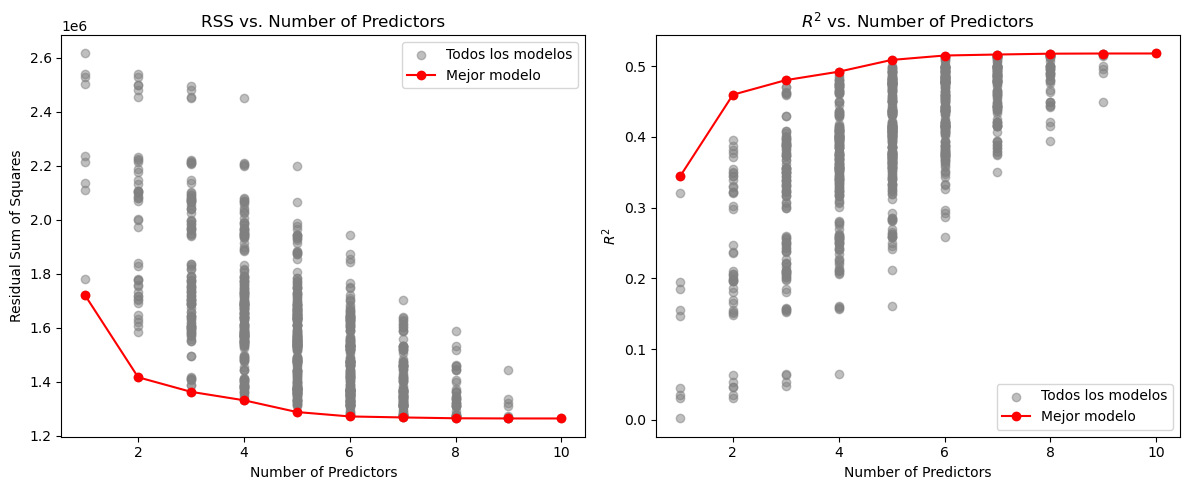

In [623]:
# Inicialización de listas para los gráficos
num_predictores = []
rss_todos = []
r2_todos = []

rss_mejores = []
r2_mejores = []
k_values = []

# Iterar por número de predictores (de 1 a p)
p = X.shape[1]
for k in range(1, p + 1):
    mejor_rss = np.inf
    mejor_r2 = -np.inf

    for subset in combinations(X.columns, k):
        X_k = add_constant(X[list(subset)])
        modelo = OLS(y, X_k).fit()
        rss = np.sum(modelo.resid ** 2)
        r2 = modelo.rsquared

        # Guardar todos los modelos (para los puntos grises)
        num_predictores.append(k)
        rss_todos.append(rss)
        r2_todos.append(r2)

        # Guardar el mejor modelo por k
        if rss < mejor_rss:
            mejor_rss = rss
        if r2 > mejor_r2:
            mejor_r2 = r2

    rss_mejores.append(mejor_rss)
    r2_mejores.append(mejor_r2)
    k_values.append(k)

# Graficar
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Panel RSS
axes[0].scatter(num_predictores, rss_todos, color='gray', alpha=0.5, label='Todos los modelos')
axes[0].plot(k_values, rss_mejores, '-o', color='red', label='Mejor modelo')
axes[0].set_xlabel('Number of Predictors')
axes[0].set_ylabel('Residual Sum of Squares')
axes[0].set_title('RSS vs. Number of Predictors')
axes[0].legend()

# Panel R²
axes[1].scatter(num_predictores, r2_todos, color='gray', alpha=0.5, label='Todos los modelos')
axes[1].plot(k_values, r2_mejores, '-o', color='red', label='Mejor modelo')
axes[1].set_xlabel('Number of Predictors')
axes[1].set_ylabel('$R^2$')
axes[1].set_title('$R^2$ vs. Number of Predictors')
axes[1].legend()

plt.tight_layout()
plt.show()

FIGURA 6.2 6.3

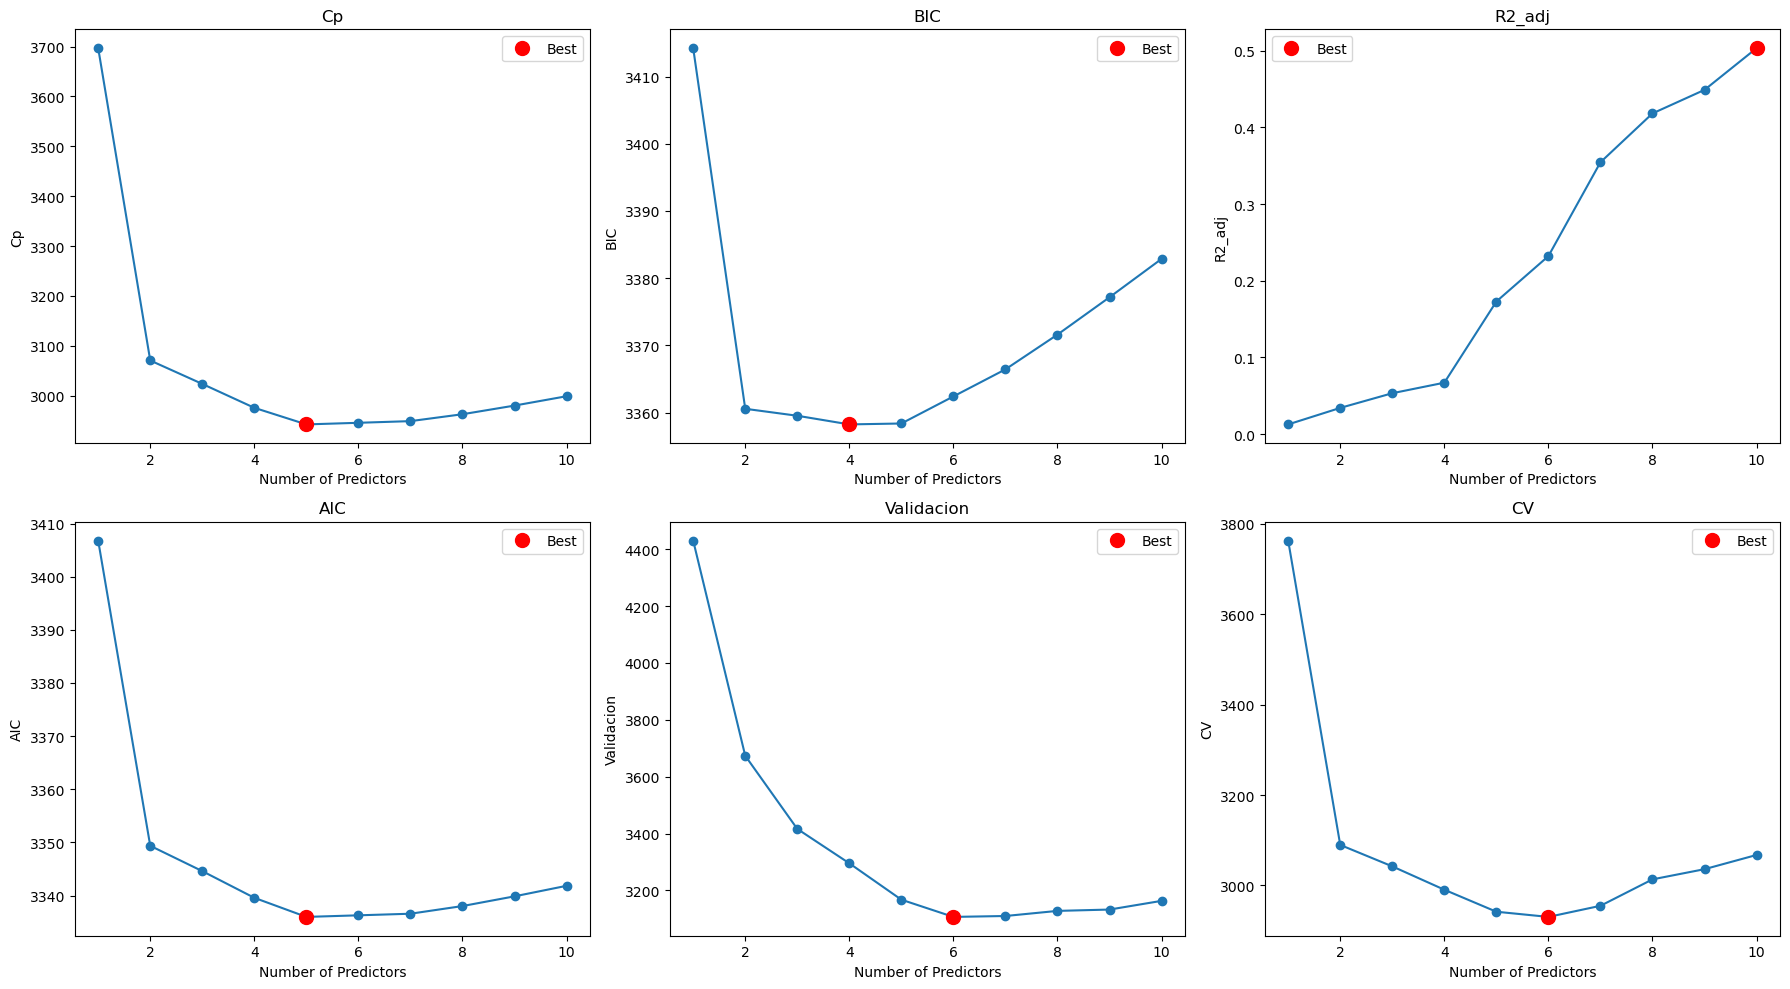

In [624]:
# Función para evaluar todos los subconjuntos de predictores
def evaluar_modelos(X, y, X_val=None, y_val=None, k_cv=5):
    p = X.shape[1]
    predictores = X.columns
    n = len(y)
    resultados = []

    # Modelo completo para Cp
    X_full = add_constant(X)
    modelo_full = OLS(y, X_full).fit()
    sigma2_hat = modelo_full.scale

    for k in range(1, p + 1):
        for subset in combinations(predictores, k):
            X_k = add_constant(X[list(subset)])
            modelo = OLS(y, X_k).fit()
            rss = np.sum(modelo.resid ** 2)

            # Cp
            cp = (rss + 2 * k * sigma2_hat) / n

            # AIC y BIC
            aic = modelo.aic
            bic = modelo.bic

            # R2 ajustado
            r2_adj = modelo.rsquared_adj

            # Validación
            val_mse = np.nan
            if X_val is not None and y_val is not None:
                X_val_red = add_constant(X_val[list(subset)])
                y_val_pred = modelo.predict(X_val_red)
                val_mse = mean_squared_error(y_val, y_val_pred)

            # Validación cruzada
            cv_mse = 0
            kf = KFold(n_splits=k_cv, shuffle=True, random_state=1)
            for train_idx, test_idx in kf.split(X):
                X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
                y_train_cv, y_test_cv = y[train_idx], y[test_idx]
                X_train_cv_red = add_constant(X_train_cv[list(subset)])
                X_test_cv_red = add_constant(X_test_cv[list(subset)])
                modelo_cv = OLS(y_train_cv, X_train_cv_red).fit()
                y_pred_cv = modelo_cv.predict(X_test_cv_red)
                cv_mse += mean_squared_error(y_test_cv, y_pred_cv)
            cv_mse /= k_cv

            resultados.append({
                'k': k,
                'predictores': subset,
                'Cp': cp,
                'AIC': aic,
                'BIC': bic,
                'R2_adj': r2_adj,
                'Validacion': val_mse,
                'CV': cv_mse
            })

    return pd.DataFrame(resultados)

# Evaluar modelos
resultados_df = evaluar_modelos(X_train, y_train, X_val, y_val)

# Gráficas
criterios = ['Cp', 'BIC', 'R2_adj', 'AIC', 'Validacion', 'CV']
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.ravel()

for i, criterio in enumerate(criterios):
    data = resultados_df.groupby('k')[criterio].min()
    axs[i].plot(data.index, data.values, marker='o', linestyle='-')
    best_k = data.idxmin() if criterio != 'R2_adj' else data.idxmax()
    best_val = data.min() if criterio != 'R2_adj' else data.max()
    axs[i].plot(best_k, best_val, 'o', markersize=10, label='Best', color='red')
    axs[i].set_title(criterio)
    axs[i].set_xlabel('Number of Predictors')
    axs[i].set_ylabel(criterio)
    axs[i].legend()

plt.tight_layout()
plt.show()


### Selección Paso a Paso hacia Adelante

Basado en el **Algortimo 2.2**

In [625]:
def seleccion_paso_a_paso_adelante(X, y, criterio='AIC', X_val=None, y_val=None, k_cv=5, verbose=True):

    p = X.shape[1]  # Número de predictores
    n = len(y)  # Número de observaciones
    predictores = X.columns  # Nombres de las columnas de X
    predictores_restantes = set(predictores)  # Inicializa un conjunto con todos los predictores
    resultados_por_k = []  # Almacena los modelos seleccionados en cada paso

    # Para Cp: modelo completo
    X_full = add_constant(X)  # Agrega la constante (intercepto)
    modelo_full = OLS(y, X_full).fit()  # Ajusta el modelo completo usando OLS
    sigma2_hat = modelo_full.scale  # Estima sigma^2, el error cuadrático medio

    # Modelo nulo (sin predictores)
    modelo_nulo = OLS(y, np.ones((n, 1))).fit()  # Modelo que predice la media de y
    resultados_por_k.append({
        'k': 0,  # El modelo nulo tiene 0 predictores
        'modelo': modelo_nulo,
        'predictores': []
    })

    # Iterar sobre el número de predictores, desde 1 hasta p
    for k in range(1, p + 1):
        mejor_r2 = -np.inf  # Inicializa el mejor R² en un valor muy negativo
        mejor_modelo_k = None  # Inicializa el mejor modelo
        mejor_predictores = None  # Inicializa la mejor combinación de predictores
        predictores_a_agregar = []  # Lista de predictores a agregar en cada paso
        
        # Evaluar todos los modelos que agregan un predictor adicional
        for predictor in predictores_restantes:
            predictores_a_probar = list(resultados_por_k[k-1]['predictores']) + [predictor]
            X_k = add_constant(X[predictores_a_probar])  # Agregar la constante
            modelo = OLS(y, X_k).fit()  # Ajusta el modelo OLS
            r2 = modelo.rsquared  # Obtiene el R² del modelo
            
            # Si el R² es mejor que el anterior, actualiza los resultados
            if r2 > mejor_r2:
                mejor_r2 = r2
                mejor_modelo_k = modelo
                mejor_predictores = predictores_a_probar
                predictor_a_agregar = predictor

        # Después de elegir el mejor predictor, eliminarlo de los predictores restantes
        predictores_restantes.remove(predictor_a_agregar)

        # Almacena los resultados del paso k
        resultados_por_k.append({
            'k': k,
            'modelo': mejor_modelo_k,
            'predictores': mejor_predictores,
        })

    # Inicializa las métricas para comparar modelos
    metricas = []
    mejores_modelos_cv = []

    # Calcula las métricas de cada modelo dependiendo del criterio elegido
    for res in resultados_por_k:
        modelo = res['modelo']

        # Selección según Cp
        if criterio == 'Cp':
            k = res['k']
            rss = np.sum(modelo.resid ** 2)  # Residual sum of squares (RSS)
            cp = (rss + 2 * k * sigma2_hat) / n  # Calcula Cp
            metricas.append(cp)

        # Selección según AIC
        elif criterio == 'AIC':
            metricas.append(modelo.aic)  # AIC del modelo ajustado

        # Selección según BIC
        elif criterio == 'BIC':
            metricas.append(modelo.bic)  # BIC del modelo ajustado

        # Selección según R² ajustado
        elif criterio == 'R2_adj':
            metricas.append(-modelo.rsquared_adj)  # R² ajustado (negado para minimización)

        # Selección según validación
        elif criterio == 'validacion':
            if X_val is None or y_val is None:
                raise ValueError("Debes proporcionar X_val e y_val para validación.")  # Validación debe tener datos
            X_val_red = add_constant(X_val[list(res['predictores'])])  # Datos de validación con los predictores seleccionados
            y_val_pred = modelo.predict(X_val_red)  # Predicciones en los datos de validación
            mse_val = mean_squared_error(y_val, y_val_pred)  # Error cuadrático medio (MSE) en validación
            metricas.append(mse_val)

        # Selección según validación cruzada
        elif criterio == 'cv':
            kf = KFold(n_splits=k_cv, shuffle=True, random_state=100)  # Dividir en k pliegues
            best_mse_k = float('inf')  # Inicializa el mejor MSE como infinito
            best_model_k = None  # Inicializa el mejor modelo

            # Realiza la validación cruzada
            for train_idx, val_idx in kf.split(X):
                X_train_k, X_val_k = X.iloc[train_idx], X.iloc[val_idx]  # Divide en entrenamiento y validación
                y_train_k, y_val_k = y[train_idx], y[val_idx]  # Divide las etiquetas
                X_train_red = add_constant(X_train_k[list(res['predictores'])])  # Datos de entrenamiento con predictores seleccionados
                modelo_k = OLS(y_train_k, X_train_red).fit()  # Ajusta el modelo en el conjunto de entrenamiento
                X_val_red = add_constant(X_val_k[list(res['predictores'])])  # Datos de validación
                y_pred_k = modelo_k.predict(X_val_red)  # Predicciones en validación
                mse_k = mean_squared_error(y_val_k, y_pred_k)  # Calcula el MSE

                # Si el MSE es mejor, actualiza el mejor modelo
                if mse_k < best_mse_k:
                    best_mse_k = mse_k
                    best_model_k = modelo_k

            # Almacena el mejor modelo encontrado en la validación cruzada
            metricas.append(best_mse_k)
            mejores_modelos_cv.append({
                'modelo': best_model_k,  # Mejor modelo encontrado
                'mse': best_mse_k,  # Mejor MSE
                'predictores': res['predictores']  # Combinación de predictores
            })

        else:
            raise ValueError("Criterio no reconocido.")  # Si el criterio no es reconocido

    # Selecciona el modelo con la mejor métrica
    idx_mejor = int(np.argmin(metricas))  # Encuentra el índice del mejor modelo (mínimo de las métricas)
    mejor_modelo = resultados_por_k[idx_mejor]  # Obtiene el mejor modelo

    # Si el criterio es validación cruzada, devuelve el mejor modelo y su MSE
    if criterio == 'cv':
        mejor_modelo_cv = mejores_modelos_cv[idx_mejor]
        if verbose:
            print(f"\n=== Mejor modelo según CV ===")
            print(f"  k = {mejor_modelo['k']}")  # Número de predictores
            print(f"  Predictores: {mejor_modelo['predictores']}")  # Combinación de predictores
            print(f"  Mejor MSE en CV: {mejor_modelo_cv['mse']:.4f}")  # MSE del mejor modelo
            print(mejor_modelo_cv['modelo'].summary())  # Resumen del modelo
        return mejor_modelo_cv, mejor_modelo_cv['mse']  # Devuelve el mejor modelo y su MSE

    # Si el criterio no es validación cruzada, devuelve el mejor modelo según el criterio seleccionado
    else:
        if verbose:
            print(f"\n========= Mejor modelo según {criterio} =========")
            print(f"  k = {mejor_modelo['k']}")  # Número de predictores
            print(f"  Predictores: {mejor_modelo['predictores']}")  # Combinación de predictores
            print(f"  Métrica ({criterio}): {metricas[idx_mejor]:.4f}")  # Métrica del mejor modelo
            print(mejor_modelo['modelo'].summary())  # Resumen del modelo
        return mejor_modelo, metricas[idx_mejor]  # Devuelve el mejor modelo y su métrica


In [626]:
# Usar Cp:
modelo_forward_cp, valor_forward_cp = seleccion_paso_a_paso_adelante(X_train, y_train, criterio='Cp', verbose=True)


========= Mejor modelo según Cp =========
  k = 5
  Predictores: ['s5', 'bmi', 's3', 'bp', 'sex']
  Métrica (Cp): 2942.3617
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     63.59
Date:                Thu, 15 May 2025   Prob (F-statistic):           3.60e-45
Time:                        10:55:07   Log-Likelihood:                -1662.0
No. Observations:                 308   AIC:                             3336.
Df Residuals:                     302   BIC:                             3358.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------

In [627]:
# Usar AIC:
modelo_forward_aic, valor_forward_aic = seleccion_paso_a_paso_adelante(X_train, y_train, criterio='AIC', verbose=True)


========= Mejor modelo según AIC =========
  k = 5
  Predictores: ['s5', 'bmi', 's3', 'bp', 'sex']
  Métrica (AIC): 3335.9869
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     63.59
Date:                Thu, 15 May 2025   Prob (F-statistic):           3.60e-45
Time:                        10:55:07   Log-Likelihood:                -1662.0
No. Observations:                 308   AIC:                             3336.
Df Residuals:                     302   BIC:                             3358.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----

In [628]:
# Usar BIC:
modelo_forward_bic, valor_forward_bic = seleccion_paso_a_paso_adelante(X_train, y_train, criterio='BIC', verbose=True)


========= Mejor modelo según BIC =========
  k = 4
  Predictores: ['s5', 'bmi', 's3', 'bp']
  Métrica (BIC): 3358.2309
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     76.95
Date:                Thu, 15 May 2025   Prob (F-statistic):           5.82e-45
Time:                        10:55:07   Log-Likelihood:                -1664.8
No. Observations:                 308   AIC:                             3340.
Df Residuals:                     303   BIC:                             3358.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

In [629]:
# Usar R2_adj:
modelo_forward_r2_adj, valor_forward_r2_adj = seleccion_paso_a_paso_adelante(X_train, y_train, criterio='R2_adj', verbose=True)


========= Mejor modelo según R2_adj =========
  k = 7
  Predictores: ['s5', 'bmi', 's3', 'bp', 'sex', 's1', 's6']
  Métrica (R2_adj): -0.5070
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.09
Date:                Thu, 15 May 2025   Prob (F-statistic):           4.52e-44
Time:                        10:55:08   Log-Likelihood:                -1660.3
No. Observations:                 308   AIC:                             3337.
Df Residuals:                     300   BIC:                             3366.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025 

In [630]:
# Usar validación (debe tener los datos de validación):
modelo_forward_val, mse_forward_val = seleccion_paso_a_paso_adelante(X_train, y_train, criterio='validacion', X_val=X_val, y_val=y_val, verbose=True)


========= Mejor modelo según validacion =========
  k = 9
  Predictores: ['s5', 'bmi', 's3', 'bp', 'sex', 's1', 's6', 's4', 's2']
  Métrica (validacion): 3158.4585
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     35.74
Date:                Thu, 15 May 2025   Prob (F-statistic):           1.59e-42
Time:                        10:55:08   Log-Likelihood:                -1660.0
No. Observations:                 308   AIC:                             3340.
Df Residuals:                     298   BIC:                             3377.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t  

In [631]:
# Usar validación cruzada con k=5:
modelo_forward_cv, mse_forward_cv = seleccion_paso_a_paso_adelante(X_combined, y_combined, criterio='cv', k_cv=5, verbose=True)


=== Mejor modelo según CV ===
  k = 8
  Predictores: ['bmi', 's5', 'bp', 's3', 'sex', 's1', 's6', 's2']
  Mejor MSE en CV: 2410.5490
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     40.27
Date:                Thu, 15 May 2025   Prob (F-statistic):           1.14e-43
Time:                        10:55:08   Log-Likelihood:                -1718.8
No. Observations:                 317   AIC:                             3456.
Df Residuals:                     308   BIC:                             3489.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.97

### Selección Paso a Paso hacia Atrás

Basado en el **Algoritmo 2.3**

In [632]:
def seleccion_paso_a_paso_atras(X, y, criterio='AIC', X_val=None, y_val=None, k_cv=5, verbose=True):

    p = X.shape[1]  # Número de predictores
    n = len(y)  # Número de observaciones
    predictores = X.columns  # Nombres de las columnas de X
    predictores_seleccionados = set(predictores)  # Inicializa un conjunto con todos los predictores
    resultados_por_k = []  # Almacena los modelos seleccionados en cada paso

    # Para Cp: modelo completo
    X_full = add_constant(X)  # Agrega la constante (intercepto)
    modelo_full = OLS(y, X_full).fit()  # Ajusta el modelo completo usando OLS
    sigma2_hat = modelo_full.scale

    # Modelo completo (con todos los predictores)
    X_completo = add_constant(X)  # Agregar la constante
    modelo_completo = OLS(y, X_completo).fit()
    resultados_por_k.append({
        'k': p,  # El modelo completo tiene p predictores
        'modelo': modelo_completo,
        'predictores': predictores.tolist()
    })

    # Iterar desde el número de predictores p hasta 1
    for k in range(p, 0, -1):
        mejor_r2 = -np.inf  # Inicializa el mejor R² en un valor muy negativo
        mejor_modelo_k = None  # Inicializa el mejor modelo
        mejor_predictores = None  # Inicializa la mejor combinación de predictores
        predictores_a_eliminar = None  # Predictor a eliminar en cada paso
        
        # Evaluar todos los modelos que eliminan un predictor
        for predictor in predictores_seleccionados:
            predictores_a_probar = list(resultados_por_k[p - k]['predictores'])
            predictores_a_probar.remove(predictor)
            X_k = add_constant(X[predictores_a_probar])  # Agregar la constante
            modelo = OLS(y, X_k).fit()  # Ajusta el modelo OLS
            r2 = modelo.rsquared  # Obtiene el R² del modelo
            
            # Si el R² es mejor que el anterior, actualiza los resultados
            if r2 > mejor_r2:
                mejor_r2 = r2
                mejor_modelo_k = modelo
                mejor_predictores = predictores_a_probar
                predictores_a_eliminar = predictor  # Corregir aquí: asignamos a la variable correcta

        # Después de elegir el mejor predictor, eliminarlo de los predictores seleccionados
        predictores_seleccionados.remove(predictores_a_eliminar)  # Usar la variable correcta

        # Almacena los resultados del paso k
        resultados_por_k.append({
            'k': k - 1,
            'modelo': mejor_modelo_k,
            'predictores': mejor_predictores,
        })

    # Inicializa las métricas para comparar modelos
    metricas = []
    mejores_modelos_cv = []

    # Calcula las métricas de cada modelo dependiendo del criterio elegido
    for res in resultados_por_k:
        modelo = res['modelo']

        # Selección según Cp
        if criterio == 'Cp':
            k = res['k']
            rss = np.sum(modelo.resid ** 2)  # Residual sum of squares (RSS)
            cp = (rss + 2 * k * sigma2_hat) / n  # Calcula Cp
            metricas.append(cp)

        # Selección según AIC
        elif criterio == 'AIC':
            metricas.append(modelo.aic)  # AIC del modelo ajustado

        # Selección según BIC
        elif criterio == 'BIC':
            metricas.append(modelo.bic)  # BIC del modelo ajustado

        # Selección según R² ajustado
        elif criterio == 'R2_adj':
            metricas.append(-modelo.rsquared_adj)  # R² ajustado (negado para minimización)

        # Selección según validación
        elif criterio == 'validacion':
            if X_val is None or y_val is None:
                raise ValueError("Debes proporcionar X_val e y_val para validación.")  # Validación debe tener datos
            X_val_red = add_constant(X_val[list(res['predictores'])])  # Datos de validación con los predictores seleccionados
            y_val_pred = modelo.predict(X_val_red)  # Predicciones en los datos de validación
            mse_val = mean_squared_error(y_val, y_val_pred)  # Error cuadrático medio (MSE) en validación
            metricas.append(mse_val)

        # Selección según validación cruzada
        elif criterio == 'cv':
            kf = KFold(n_splits=k_cv, shuffle=True, random_state=100)  # Dividir en k pliegues
            best_mse_k = float('inf')  # Inicializa el mejor MSE como infinito
            best_model_k = None  # Inicializa el mejor modelo

            # Realiza la validación cruzada
            for train_idx, val_idx in kf.split(X):
                X_train_k, X_val_k = X.iloc[train_idx], X.iloc[val_idx]  # Divide en entrenamiento y validación
                y_train_k, y_val_k = y[train_idx], y[val_idx]  # Divide las etiquetas
                X_train_red = add_constant(X_train_k[list(res['predictores'])])  # Datos de entrenamiento con predictores seleccionados
                modelo_k = OLS(y_train_k, X_train_red).fit()  # Ajusta el modelo en el conjunto de entrenamiento
                X_val_red = add_constant(X_val_k[list(res['predictores'])])  # Datos de validación
                y_pred_k = modelo_k.predict(X_val_red)  # Predicciones en validación
                mse_k = mean_squared_error(y_val_k, y_pred_k)  # Calcula el MSE

                # Si el MSE es mejor, actualiza el mejor modelo
                if mse_k < best_mse_k:
                    best_mse_k = mse_k
                    best_model_k = modelo_k

            # Almacena el mejor modelo encontrado en la validación cruzada
            metricas.append(best_mse_k)
            mejores_modelos_cv.append({
                'modelo': best_model_k,  # Mejor modelo encontrado
                'mse': best_mse_k,  # Mejor MSE
                'predictores': res['predictores']  # Combinación de predictores
            })

        else:
            raise ValueError("Criterio no reconocido.")  # Si el criterio no es reconocido

    # Selecciona el modelo con la mejor métrica
    idx_mejor = int(np.argmin(metricas))  # Encuentra el índice del mejor modelo (mínimo de las métricas)
    mejor_modelo = resultados_por_k[idx_mejor]  # Obtiene el mejor modelo

    # Si el criterio es validación cruzada, devuelve el mejor modelo y su MSE
    if criterio == 'cv':
        mejor_modelo_cv = mejores_modelos_cv[idx_mejor]
        if verbose:
            print(f"\n=== Mejor modelo según CV ===")
            print(f"  k = {mejor_modelo['k']}")  # Número de predictores
            print(f"  Predictores: {mejor_modelo['predictores']}")  # Combinación de predictores
            print(f"  Mejor MSE en CV: {mejor_modelo_cv['mse']:.4f}")  # MSE del mejor modelo
            print(mejor_modelo_cv['modelo'].summary())  # Resumen del modelo
        return mejor_modelo_cv, mejor_modelo_cv['mse']  # Devuelve el mejor modelo y su MSE

    # Si el criterio no es validación cruzada, devuelve el mejor modelo según el criterio seleccionado
    else:
        if verbose:
            print(f"\n========= Mejor modelo según {criterio} =========")
            print(f"  k = {mejor_modelo['k']}")  # Número de predictores
            print(f"  Predictores: {mejor_modelo['predictores']}")  # Combinación de predictores
            print(f"  Métrica ({criterio}): {metricas[idx_mejor]:.4f}")  # Métrica del mejor modelo
            print(mejor_modelo['modelo'].summary())  # Resumen del modelo
        return mejor_modelo, metricas[idx_mejor]  # Devuelve el mejor modelo y su métrica

In [633]:
# Usar Cp:
modelo_backward_cp, valor_backward_cp = seleccion_paso_a_paso_atras(X_train, y_train, criterio='Cp', verbose=True)


========= Mejor modelo según Cp =========
  k = 6
  Predictores: ['sex', 'bmi', 'bp', 's1', 's4', 's5']
  Métrica (Cp): 2946.7315
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     53.34
Date:                Thu, 15 May 2025   Prob (F-statistic):           1.42e-44
Time:                        10:55:09   Log-Likelihood:                -1661.2
No. Observations:                 308   AIC:                             3336.
Df Residuals:                     301   BIC:                             3363.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]


In [634]:
# Usar AIC:
modelo_backward_aic, valor_backward_aic = seleccion_paso_a_paso_atras(X_train, y_train, criterio='AIC', verbose=True)


========= Mejor modelo según AIC =========
  k = 6
  Predictores: ['sex', 'bmi', 'bp', 's1', 's4', 's5']
  Métrica (AIC): 3336.4092
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     53.34
Date:                Thu, 15 May 2025   Prob (F-statistic):           1.42e-44
Time:                        10:55:09   Log-Likelihood:                -1661.2
No. Observations:                 308   AIC:                             3336.
Df Residuals:                     301   BIC:                             3363.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975

In [635]:
# Usar BIC:
modelo_backward_bic, valor_backward_bic = seleccion_paso_a_paso_atras(X_train, y_train, criterio='BIC', verbose=True)


========= Mejor modelo según BIC =========
  k = 4
  Predictores: ['bmi', 'bp', 's1', 's5']
  Métrica (BIC): 3360.4597
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     75.85
Date:                Thu, 15 May 2025   Prob (F-statistic):           1.73e-44
Time:                        10:55:09   Log-Likelihood:                -1665.9
No. Observations:                 308   AIC:                             3342.
Df Residuals:                     303   BIC:                             3360.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

In [636]:
# Usar R2_adj:
modelo_backward_r2_adj, valor_backward_r2_adj = seleccion_paso_a_paso_atras(X_train, y_train, criterio='R2_adj', verbose=True)


========= Mejor modelo según R2_adj =========
  k = 7
  Predictores: ['sex', 'bmi', 'bp', 's1', 's4', 's5', 's6']
  Métrica (R2_adj): -0.5067
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.04
Date:                Thu, 15 May 2025   Prob (F-statistic):           4.92e-44
Time:                        10:55:10   Log-Likelihood:                -1660.4
No. Observations:                 308   AIC:                             3337.
Df Residuals:                     300   BIC:                             3367.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025 

In [637]:
# Usar validación (debe tener los datos de validación):
modelo_backward_val, mse_backward_val = seleccion_paso_a_paso_atras(X_train, y_train, criterio='validacion', X_val=X_val, y_val=y_val, verbose=True)


========= Mejor modelo según validacion =========
  k = 8
  Predictores: ['sex', 'bmi', 'bp', 's1', 's2', 's4', 's5', 's6']
  Métrica (validacion): 3153.6309
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     40.34
Date:                Thu, 15 May 2025   Prob (F-statistic):           2.45e-43
Time:                        10:55:10   Log-Likelihood:                -1660.0
No. Observations:                 308   AIC:                             3338.
Df Residuals:                     299   BIC:                             3372.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>

In [638]:
# Usar validación cruzada con k=5:
modelo_backward_cv, mse_backward_cv = seleccion_paso_a_paso_atras(X_combined, y_combined, criterio='cv', k_cv=5, verbose=True)


=== Mejor modelo según CV ===
  k = 7
  Predictores: ['sex', 'bmi', 'bp', 's1', 's2', 's5', 's6']
  Mejor MSE en CV: 2398.6032
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     46.07
Date:                Thu, 15 May 2025   Prob (F-statistic):           1.91e-44
Time:                        10:55:10   Log-Likelihood:                -1719.0
No. Observations:                 317   AIC:                             3454.
Df Residuals:                     309   BIC:                             3484.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---

# Métodos de Penalización

Es muy importante estandarizar los datos, ya que los modelos siguientes son muy sensibles a la escala. Aunque nuestros datos ya están estandarizados, a continuación te muestro cómo se realizaría este proceso.

NOTA: El parámetro $\lambda$ se llama alpha en Sklearn. 

In [639]:
# Escalar
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)

### Ridge Regression

Si simplemente queremos saber cuáles son los coeficientes que calcula la Ridge Regression para un valor específico de $\lambda$ (alpha), podemos utilizar la función **Ridge()** del módulo sklearn.linear_model. Esta permite ajustar el modelo con un valor fijo de regularización y obtener directamente los coeficientes.

In [640]:
# Crear el modelo Ridge con un valor de alpha (λ) de 10
ridge = Ridge(alpha=1)

# Ajustar el modelo Ridge a los datos estandarizados de entrenamiento
ridge.fit(X_train, y_train)

# Crear un DataFrame con los coeficientes del modelo y los nombres de las características (predictores)
coef_df = pd.DataFrame({
    'Feature': X_train.columns,  # Columnas de las características del conjunto de datos de entrenamiento
    'Coefficient': ridge.coef_   # Coeficientes obtenidos por el modelo Ridge
})

# Agregar una nueva columna con los valores absolutos de los coeficientes
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()

# Ordenar el DataFrame según el valor absoluto de los coeficientes en orden descendente
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Imprimir los coeficientes ordenados, mostrando los más influyentes primero
print("\nCoeficientes de la regresión Ridge:")
print(coef_df)


Coeficientes de la regresión Ridge:
  Feature  Coefficient  Abs_Coefficient
8      s5   247.980265       247.980265
2     bmi   244.959853       244.959853
3      bp   144.080041       144.080041
6      s3  -139.054152       139.054152
9      s6   123.733641       123.733641
7      s4   122.322948       122.322948
0     age    26.966906        26.966906
4      s1    26.549863        26.549863
1     sex   -24.676215        24.676215
5      s2   -13.438691        13.438691


En cambio, si queremos encontrar para qué valor de $\lambda$ (alpha) se obtiene el mejor modelo, podemos utilizar **RidgeCV**, que realiza una validación cruzada para seleccionar automáticamente el valor óptimo de alpha. Este proceso evalúa el rendimiento del modelo en diferentes particiones de los datos y elige el alpha que minimiza el error.

NOTA: Si no especificamos sobre que alphas queremos que trabaje RidgeCV(), por defecto, trabajara con alphas=[0.1, 1.0, 10.0]

El valor óptimo de alpha es: 0.1

Coeficientes del mejor modelo (Ridge Regression):
  Feature  Coefficient  Abs_Coefficient
8      s5   486.689222       486.689222
2     bmi   440.911417       440.911417
3      bp   223.590316       223.590316
6      s3  -185.345911       185.345911
1     sex  -132.891425       132.891425
7      s4   124.361972       124.361972
9      s6   122.224934       122.224934
5      s2  -102.757009       102.757009
4      s1   -14.470770        14.470770
0     age   -11.412519        11.412519

MSE en entrenamiento: 2837.5947
R² en entrenamiento: 0.5146


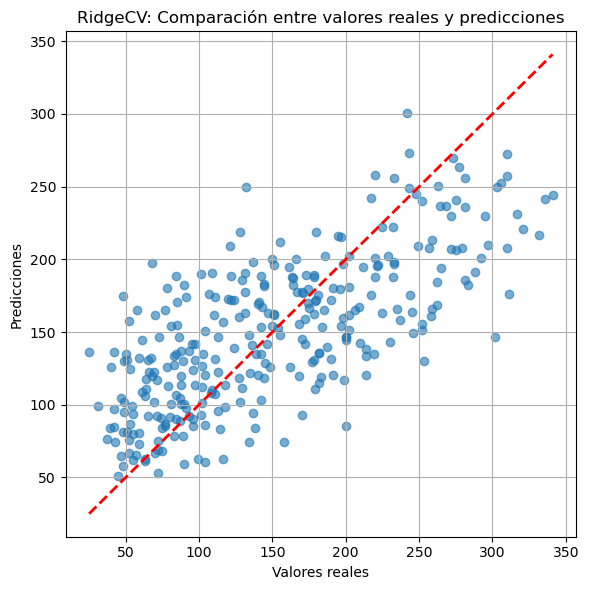

In [641]:
# Definir valores de alpha (desde 10^-6 a 10^6)
alphas = np.logspace(-6, 6, 13)

# Ajustar modelo RidgeCV con validación cruzada
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train, y_train)

# Mostrar el mejor alpha encontrado
print(f"El valor óptimo de alpha es: {ridge_cv.alpha_}")

# Crear DataFrame con coeficientes y ordenarlos
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': ridge_cv.coef_
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("\nCoeficientes del mejor modelo (Ridge Regression):")
print(coef_df) 

# Hacer predicciones en los datos de entrenamiento
y_pred = ridge_cv.predict(X_train)

# Calcular métricas de rendimiento
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"\nMSE en entrenamiento: {mse:.4f}")
print(f"R² en entrenamiento: {r2:.4f}")

# Visualización de predicciones vs valores reales
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('RidgeCV: Comparación entre valores reales y predicciones')
plt.grid(True)
plt.tight_layout()
plt.show()

In [642]:
# Calcular el error cuadrático medio (MSE) promedio de la validación cruzada para cada valor de alpha (λ)
cv_mse = np.mean(ridge_cv.cv_values_, axis=0)

# Crear un DataFrame para almacenar los resultados, incluyendo los valores de alpha y los MSE promedio
results_df = pd.DataFrame({
    'Alpha (lambda)': ridge_cv.alphas,  # Valores de alpha (λ) utilizados en la validación cruzada
    'Mean Val Score (MSE)': cv_mse    # MSE promedio obtenido para cada valor de alpha
})

# Añadir una columna con el ranking de los MSE (menor MSE tiene el rango más alto)
results_df['Rank Val Score'] = results_df['Mean Val Score (MSE)'].rank(method='min')

# Ordenar el DataFrame por el ranking de MSE, de menor a mayor MSE
results_df = results_df.sort_values(by='Rank Val Score')

# Imprimir el DataFrame resultante para mostrar los valores de alpha y sus respectivos rankings de MSE
print(results_df)

    Alpha (lambda)  Mean Val Score (MSE)  Rank Val Score
5         0.100000           2997.246491             1.0
4         0.010000           3009.506206             2.0
3         0.001000           3021.362389             3.0
2         0.000100           3024.340934             4.0
1         0.000010           3024.700915             5.0
0         0.000001           3024.737687             6.0
6         1.000000           3427.563608             7.0
7        10.000000           4992.889376             8.0
8       100.000000           5764.286052             9.0
9      1000.000000           5871.496162            10.0
10    10000.000000           5882.629939            11.0
11   100000.000000           5883.747597            12.0
12  1000000.000000           5883.859405            13.0


Otra forma seria aplicando **GridSearchCV** al Ridge(). Siempre tenemos que especificar los valores de alpha con los que queremos que trabaje. 

In [643]:
# Definir el grid de valores para alpha (lambda)
param_grid = {
    'alpha': np.logspace(-6, 6, 13)
}

# Crear un scorer basado en MSE (menor es mejor)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Configurar el GridSearchCV con Ridge
grid_search = GridSearchCV(
    estimator=Ridge(),
    param_grid=param_grid,
    cv=5,  # Validación cruzada con 5 pliegues
    scoring=mse_scorer,
    return_train_score=True
)

# Ajustar el modelo en el conjunto de entrenamiento y validación
grid_search.fit(X_combined, y_combined)

# Ver el mejor modelo
best_model = grid_search.best_estimator_

# Extraer resultados del grid_search
results = grid_search.cv_results_

# Crear un DataFrame para mostrar los resultados de manera ordenada
results_df = pd.DataFrame({
    'Alpha (lambda)': results['param_alpha'],
    'Mean Val Score (MSE)': -results['mean_test_score'],  # Negamos para obtener el valor positivo
    'Std Val Score': results['std_test_score'],
    'Mean Train Score (MSE)': -results['mean_train_score'],
    'Std Train Score': results['std_train_score'],
    'Rank Val Score': results['rank_test_score']
})

# Ordenar los resultados por la puntuación de la prueba (MSE)
results_df = results_df.sort_values(by='Rank Val Score')

# Mostrar el mejor valor de alpha que eligió GridSearchCV
print(f"\nMejor valor de alpha (lambda) seleccionado: {grid_search.best_params_['alpha']}")

# Obtener los coeficientes del mejor modelo
coefficients = best_model.coef_

# Crear un DataFrame para mostrar los coeficientes junto con los nombres de las características
coef_df = pd.DataFrame({
    'Feature': X_train.columns,  # Si X_train es un DataFrame con nombres de columna
    'Coefficient': coefficients
})

# Ordenar los coeficientes por valor absoluto para ver cuáles tienen mayor impacto
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar los coeficientes ordenados
print(f"\nCoeficientes del mejor modelo:")
print(coef_df)



Mejor valor de alpha (lambda) seleccionado: 0.01

Coeficientes del mejor modelo:
  Feature  Coefficient  Abs_Coefficient
8      s5   604.649296       604.649296
2     bmi   507.226206       507.226206
3      bp   322.671160       322.671160
4      s1  -297.867412       297.867412
1     sex  -207.631287       207.631287
5      s2   122.129178       122.129178
6      s3  -116.074819       116.074819
7      s4    97.330513        97.330513
9      s6    80.550031        80.550031
0     age   -13.836894        13.836894


In [644]:
print("Resultados de la búsqueda con validación cruzada (Ridge Regression):")
results_df

Resultados de la búsqueda con validación cruzada (Ridge Regression):


,Alpha (lambda),Mean Val Score (MSE),Std Val Score,Mean Train Score (MSE),Std Train Score,Rank Val Score
4,0.01,3057.910647,506.768920,2850.021051,119.713213,1
5,0.1,3060.721057,475.914140,2881.701214,120.757570,2
3,0.001,3061.818773,497.158993,2842.786925,117.450698,3
2,0.0001,3063.796435,493.373188,2842.406705,117.344418,4
1,0.00001,3064.060622,492.918376,2842.401685,117.343070,5
0,0.000001,3064.087883,492.872012,2842.401633,117.343056,6
6,1.0,3501.537020,487.617730,3387.792609,102.980093,7
7,10.0,5150.514833,690.508245,5076.513144,151.944488,8
8,100.0,5975.130020,751.353795,5909.496383,189.356989,9
9,1000.0,6090.316029,758.462732,6025.740898,194.865481,10


Cuando el espacio de hiperparámetros es muy amplio o el costo computacional de evaluar todas las combinaciones posibles es alto, existen alternativas más eficientes a **GridSearchCV**. Una de ellas es **RandomizedSearchCV**, que selecciona combinaciones de hiperparámetros de manera aleatoria, permitiendo controlar el número de pruebas a realizar. Esta estrategia reduce el tiempo de búsqueda en comparación con una exploración exhaustiva.

Como punto intermedio entre una búsqueda exhaustiva y una aleatoria, **HalvingRandomSearchCV** ofrece una solución aún más eficiente. Este método comienza evaluando muchas combinaciones utilizando una fracción reducida de los datos y, en cada iteración, incrementa el tamaño de la muestra. A medida que avanza, se enfoca solo en los modelos que han mostrado un mejor desempeño, lo que permite ahorrar tiempo sin sacrificar una gran precisión en la selección de los hiperparámetros.

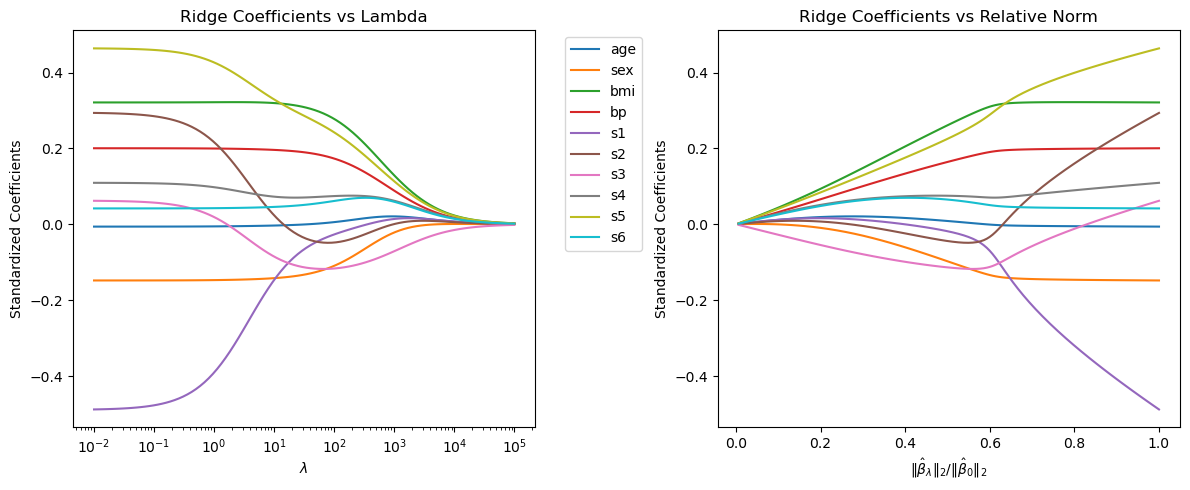

In [645]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# Suponiendo que ya tienes X (DataFrame) e y definidos
X_std = StandardScaler().fit_transform(X)
y_std = (y - y.mean()) / y.std()

coefs = []
lambdas = np.logspace(-2, 5, 100)

# Ajustamos Ridge para cada valor de lambda
for l in lambdas:
    ridge = Ridge(alpha=l, fit_intercept=False)
    ridge.fit(X_std, y_std)
    coefs.append(ridge.coef_)

coefs = np.array(coefs)

# Creamos la gráfica
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Izquierda: Coeficientes vs lambda
for i in range(X.shape[1]):
    axes[0].plot(lambdas, coefs[:, i])
axes[0].set_xscale('log')
axes[0].set_xlabel(r'$\lambda$')
axes[0].set_ylabel('Standardized Coefficients')
axes[0].set_title('Ridge Coefficients vs Lambda')
axes[0].legend(X.columns, bbox_to_anchor=(1.05, 1), loc='upper left')

# Derecha: Coef vs norma relativa
norms = np.linalg.norm(coefs, axis=1) / np.linalg.norm(coefs[0])
for i in range(X.shape[1]):
    axes[1].plot(norms, coefs[:, i])
axes[1].set_xlabel(r'$\|\hat{\beta}_\lambda\|_2 / \|\hat{\beta}_0\|_2$')
axes[1].set_ylabel('Standardized Coefficients')
axes[1].set_title('Ridge Coefficients vs Relative Norm')

plt.tight_layout()
plt.show()


### LASSO

Todo lo visto anteriormente con el Ridge Regression se puede aplicar también al LASSO

In [646]:
# Ajustar el modelo LASSO con un valor específico de alpha
lasso = Lasso(alpha=0.01, max_iter=10000)
lasso.fit(X_train, y_train)

# Crear DataFrame con coeficientes y ordenarlos por valor absoluto
coef_df_lasso = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso.coef_
})

# Añadir columna con los valores absolutos
coef_df_lasso['Abs_Coefficient'] = coef_df_lasso['Coefficient'].abs()

# Ordenar por valor absoluto de los coeficientes
coef_df_lasso = coef_df_lasso.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar los coeficientes ordenados
print("\nCoeficientes del modelo LASSO")
print(coef_df_lasso)


Coeficientes del modelo LASSO
  Feature  Coefficient  Abs_Coefficient
8      s5   626.478726       626.478726
2     bmi   489.887988       489.887988
3      bp   230.519648       230.519648
4      s1  -157.603625       157.603625
1     sex  -155.438806       155.438806
6      s3  -148.353010       148.353010
9      s6    99.538355        99.538355
7      s4    85.860607        85.860607
0     age   -21.488055        21.488055
5      s2    -0.000000         0.000000


Si no especificamos sobre que alphas queremos que LassoCV() trabaje, este genera automáticamente una secuencia de valores basada en los datos de entrada. LassoCV calcula internamente un valor máximo de alpha (alpha_max) a partir de los datos, que es el menor valor de alpha tal que todos los coeficientes del modelo son cero. Luego crea por defecto una secuencia de n_alphas=100 valores, logarítmicamente espaciados entre alpha_max y alpha_max * 1e-3.

El valor óptimo de alpha es: 0.076100

Coeficientes del mejor modelo (Lasso):
  Feature  Coefficient  Abs_Coefficient
8      s5   567.863192       567.863192
2     bmi   482.778773       482.778773
6      s3  -218.541673       218.541673
3      bp   191.759315       191.759315
1     sex  -103.514804       103.514804
9      s6    76.762688        76.762688
5      s2   -46.026413        46.026413
0     age    -0.000000         0.000000
4      s1    -0.000000         0.000000
7      s4     0.000000         0.000000

MSE en entrenamiento: 2836.6293
R² en entrenamiento: 0.5148


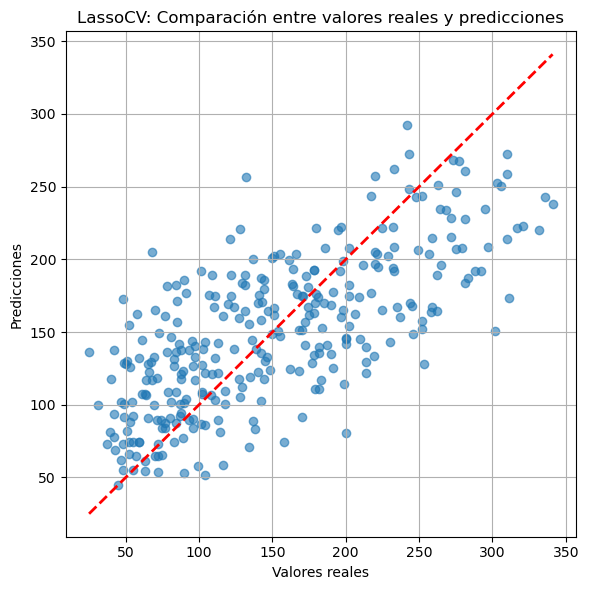

In [647]:
# Ajustar modelo LassoCV con validación cruzada
lasso_cv = LassoCV(cv=5, max_iter=10000)
lasso_cv.fit(X_train, y_train)

# Mostrar el mejor alpha encontrado
print(f"El valor óptimo de alpha es: {lasso_cv.alpha_:.6f}")

# Crear DataFrame con coeficientes y ordenarlos por impacto
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso_cv.coef_
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar top 10 características más relevantes
print("\nCoeficientes del mejor modelo (Lasso):")
print(coef_df.head(10))

# Hacer predicciones en los datos de entrenamiento
y_pred = lasso_cv.predict(X_train)

# Calcular métricas de rendimiento
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"\nMSE en entrenamiento: {mse:.4f}")
print(f"R² en entrenamiento: {r2:.4f}")

# Visualización de predicciones vs. valores reales
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('LassoCV: Comparación entre valores reales y predicciones')
plt.grid(True)
plt.tight_layout()
plt.show()


In [648]:
# Obtener el MSE promedio por alpha
cv_mse = np.mean(lasso_cv.mse_path_, axis=1)

# Crear DataFrame con los resultados
results_df = pd.DataFrame({
    'Alpha (lambda)': lasso_cv.alphas_,  # Valores de alpha evaluados
    'Mean Val Score (MSE)': cv_mse       # MSE promedio para cada alpha
})

# Añadir ranking por MSE (menor MSE = mejor alpha)
results_df['Rank Val Score'] = results_df['Mean Val Score (MSE)'].rank(method='min')

# Ordenar por el mejor desempeño
results_df = results_df.sort_values(by='Rank Val Score')

# Mostrar resultados
print(results_df)

    Alpha (lambda)  Mean Val Score (MSE)  Rank Val Score
48        0.076100           3070.830316             1.0
47        0.081600           3070.840726             2.0
49        0.070971           3071.286075             3.0
46        0.087497           3071.364756             4.0
50        0.066188           3071.885163             5.0
..             ...                   ...             ...
4         1.639526           4838.530536            96.0
3         1.758010           5080.068701            97.0
2         1.885057           5335.674645            98.0
1         2.021285           5613.874423            99.0
0         2.167357           5859.863342           100.0

[100 rows x 3 columns]


In [649]:
# Definir el grid de valores para alpha (lambda)
param_grid = {
    'alpha': np.logspace(-6, 6, 13)
}

# Crear un scorer basado en MSE (menor es mejor)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Configurar el GridSearchCV con Lasso
grid_search = GridSearchCV(
    estimator=Lasso(max_iter=10000),  # Aumentamos max_iter para evitar warnings de convergencia
    param_grid=param_grid,
    cv=5,  # Validación cruzada con 5 pliegues
    scoring=mse_scorer,
    return_train_score=True
)

# Ajustar el modelo en el conjunto combinado (ya escalado)
grid_search.fit(X_combined, y_combined)

# Obtener el mejor modelo encontrado
best_model = grid_search.best_estimator_

# Extraer resultados del grid_search
results = grid_search.cv_results_

# Crear un DataFrame con los resultados de la validación cruzada
results_df = pd.DataFrame({
    'Alpha (lambda)': results['param_alpha'],
    'Mean Val Score (MSE)': -results['mean_test_score'],
    'Std Val Score': results['std_test_score'],
    'Mean Train Score (MSE)': -results['mean_train_score'],
    'Std Train Score': results['std_train_score'],
    'Rank Val Score': results['rank_test_score']
})

# Ordenar los resultados por la puntuación de validación (MSE)
results_df = results_df.sort_values(by='Rank Val Score')

# Obtener los coeficientes del mejor modelo Lasso
coefficients = best_model.coef_

# Crear un DataFrame con los nombres de las características y sus coeficientes
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
})

# Ordenar los coeficientes por su valor absoluto
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar los coeficientes ordenados
print(f"\nCoeficientes del mejor modelo Lasso (alpha = {best_model.alpha}):")
print(coef_df)


Coeficientes del mejor modelo Lasso (alpha = 0.1):
  Feature  Coefficient  Abs_Coefficient
8      s5   505.668457       505.668457
2     bmi   500.846158       500.846158
3      bp   278.751857       278.751857
6      s3  -215.322092       215.322092
1     sex  -131.713428       131.713428
9      s6    44.825100        44.825100
4      s1   -20.079822        20.079822
0     age    -0.000000         0.000000
5      s2    -0.000000         0.000000
7      s4     0.000000         0.000000


In [650]:
print("Resultados de la búsqueda con validación cruzada (Lasso):")
results_df

Resultados de la búsqueda con validación cruzada (Lasso):


,Alpha (lambda),Mean Val Score (MSE),Std Val Score,Mean Train Score (MSE),Std Train Score,Rank Val Score
5,0.1,3059.157921,515.194728,2891.852086,127.532217,1
4,0.01,3062.132449,512.230083,2849.503076,118.091589,2
3,0.001,3063.261437,495.496071,2842.565031,117.370235,3
2,0.0001,3063.992104,493.127432,2842.403267,117.343327,4
1,0.00001,3064.080881,492.892882,2842.401649,117.343058,5
0,0.000001,3064.089916,492.869453,2842.401632,117.343056,6
6,1.0,3863.727493,626.715009,3773.998279,128.043936,7
7,10.0,6103.621424,759.265556,6039.167685,195.506346,8
8,100.0,6103.621424,759.265556,6039.167685,195.506346,8
9,1000.0,6103.621424,759.265556,6039.167685,195.506346,8


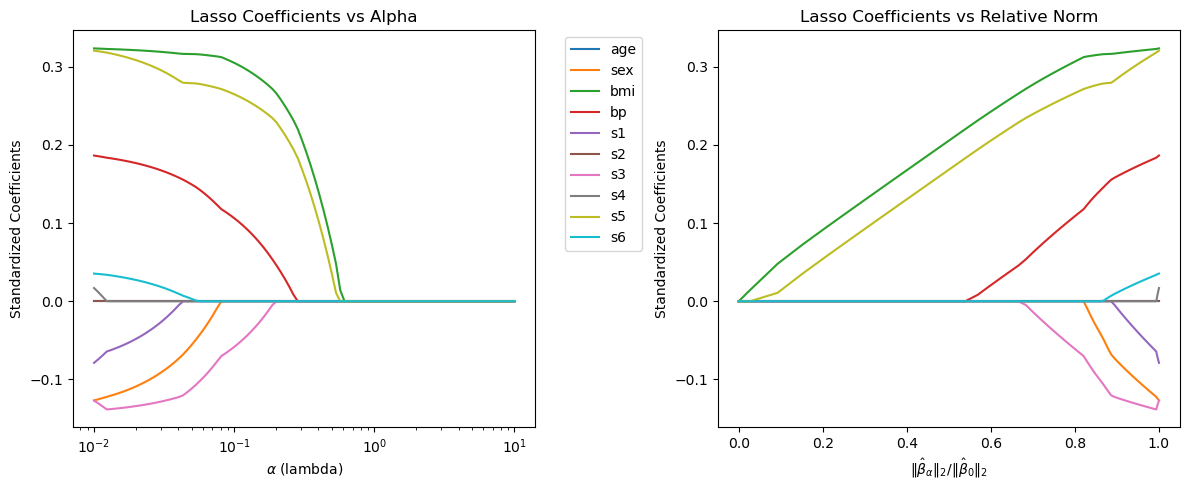

In [651]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Supongo que ya tienes X (DataFrame) e y definidos
X_std = StandardScaler().fit_transform(X)
y_std = (y - y.mean()) / y.std()

coefs = []
alphas = np.logspace(-2, 1, 100)  # Valores para el parámetro alpha (lambda)

for a in alphas:
    lasso = Lasso(alpha=a, fit_intercept=False, max_iter=10000)
    lasso.fit(X_std, y_std)
    coefs.append(lasso.coef_)

coefs = np.array(coefs)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfica 1: coeficientes vs alpha (lambda)
for i in range(X.shape[1]):
    axes[0].plot(alphas, coefs[:, i])
axes[0].set_xscale('log')
axes[0].set_xlabel(r'$\alpha$ (lambda)')
axes[0].set_ylabel('Standardized Coefficients')
axes[0].set_title('Lasso Coefficients vs Alpha')
axes[0].legend(X.columns, bbox_to_anchor=(1.05, 1), loc='upper left')

# Gráfica 2: coeficientes vs norma relativa
norms = np.linalg.norm(coefs, axis=1) / np.linalg.norm(coefs[0])
for i in range(X.shape[1]):
    axes[1].plot(norms, coefs[:, i])
axes[1].set_xlabel(r'$\|\hat{\beta}_\alpha\|_2 / \|\hat{\beta}_0\|_2$')
axes[1].set_ylabel('Standardized Coefficients')
axes[1].set_title('Lasso Coefficients vs Relative Norm')

plt.tight_layout()
plt.show()


### ElasticNet

ElasticNet es un modelo de regresión lineal regularizada que combina las penalizaciones de Lasso (L1) y Ridge (L2).

Es ideal cuando:
- Hay muchas variables predictoras.
- Existe multicolinealidad entre las variables.
- Se quiere un equilibrio entre selección de variables y estabilidad del modelo.

Minimiza:

$\text{RSS} + \alpha \left( \lambda \sum | \beta_j | + (1 - \lambda) \sum \beta_j^2 \right)$

Donde:
- RSS: Suma de errores cuadrados.
- $\alpha$ (alpha): Controla la fuerza de la regularización.
- $\lambda$ (l1_ratio): Controla la proporción entre Lasso (L1) y Ridge (L2).

  - l1_ratio = 1 → Lasso puro.
  - l1_ratio = 0 → Ridge puro.


#####  Ventajas del ElasticNet

- Selecciona automáticamente variables relevantes (como Lasso).
- Reduce la varianza y mejora la estabilidad en presencia de multicolinealidad (como Ridge).
- Útil cuando:
  - Hay más variables que observaciones.
  - Lasso por sí solo elimina demasiadas variables importantes.
  - Las variables están correlacionadas entre sí.


##### Implementación en scikit-learn

- ElasticNet: Ajuste manual de alpha y l1_ratio.
- ElasticNetCV: Selección automática de los mejores hiperparámetros mediante validación cruzada.

In [652]:
# Ajustar el modelo ElasticNet con valores específicos de alpha y l1_ratio
elastic_net = ElasticNet(alpha=1, l1_ratio=0.5, max_iter=10000)
elastic_net.fit(X_train, y_train)

# Crear DataFrame con coeficientes y ordenarlos por valor absoluto
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': elastic_net.coef_
})

# Añadir columna para los coeficientes en valor absoluto
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()

# Ordenar por valor absoluto de los coeficientes
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar los coeficientes ordenados
print("\nCoeficientes del ElasticNet")
print(coef_df)


Coeficientes del ElasticNet
  Feature  Coefficient  Abs_Coefficient
8      s5     3.293929         3.293929
2     bmi     3.139632         3.139632
7      s4     2.398612         2.398612
6      s3    -2.039766         2.039766
9      s6     2.037483         2.037483
3      bp     1.766514         1.766514
4      s1     0.654933         0.654933
5      s2     0.379139         0.379139
0     age     0.287808         0.287808
1     sex     0.000000         0.000000


Si no especificamos los parámteros alpha y l1_ratio en ElasticNetCV(), los parámetros alpha son escogidos al igual que en LassoCV(), mientras que el l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1].

Mejor alpha encontrado: 0.004334714632652479
Mejor l1_ratio encontrado: 0.50

Coeficientes del mejor modelo (ElasticNet):
  Feature  Coefficient  Abs_Coefficient
8      s5   295.029556       295.029556
2     bmi   289.038812       289.038812
3      bp   164.820130       164.820130
6      s3  -154.006375       154.006375
9      s6   131.817999       131.817999
7      s4   128.955326       128.955326
1     sex   -44.227177        44.227177
5      s2   -30.980293        30.980293
0     age    21.370699        21.370699
4      s1    19.802758        19.802758

MSE en entrenamiento: 3158.2767
R² en entrenamiento: 0.4597


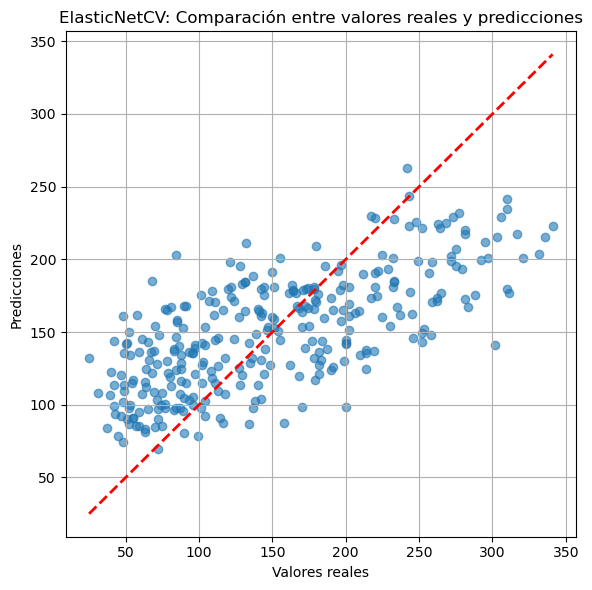

In [653]:
# Ajustar modelo ElasticNetCV con validación cruzada
elastic_cv = ElasticNetCV(cv=5, max_iter=10000)
elastic_cv.fit(X_train, y_train)

# Mostrar el mejor alpha y l1_ratio encontrados
print(f"Mejor alpha encontrado: {elastic_cv.alpha_}")
print(f"Mejor l1_ratio encontrado: {elastic_cv.l1_ratio_:.2f}")

# Crear DataFrame con coeficientes y ordenarlos
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': elastic_cv.coef_
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("\nCoeficientes del mejor modelo (ElasticNet):")
print(coef_df.head(10))  # Top 10 características más relevantes

# Hacer predicciones en los datos de entrenamiento
y_pred = elastic_cv.predict(X_train)

# Calcular métricas de rendimiento
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"\nMSE en entrenamiento: {mse:.4f}")
print(f"R² en entrenamiento: {r2:.4f}")

# Visualización de predicciones vs valores reales
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('ElasticNetCV: Comparación entre valores reales y predicciones')
plt.grid(True)
plt.tight_layout()
plt.show()

In [654]:
# Obtener el MSE promedio por alpha para el mejor l1_ratio encontrado
cv_mse = np.mean(elastic_cv.mse_path_, axis=1)  # promedio sobre las folds

# Crear DataFrame con los resultados
results_df = pd.DataFrame({
    'Alpha (lambda)': elastic_cv.alphas_,
    'Mean Val Score (MSE)': cv_mse
})

# Agregar ranking de MSE
results_df['Rank Val Score'] = results_df['Mean Val Score (MSE)'].rank(method='min')

# Ordenar por ranking
results_df = results_df.sort_values(by='Rank Val Score')

# Mostrar resultados
print(f"Mejor combinación encontrada: alpha = {elastic_cv.alpha_}, l1_ratio = {elastic_cv.l1_ratio_}")
print("\nResultados por alpha para el mejor l1_ratio:")
print(results_df)

Mejor combinación encontrada: alpha = 0.004334714632652479, l1_ratio = 0.5

Resultados por alpha para el mejor l1_ratio:
    Alpha (lambda)  Mean Val Score (MSE)  Rank Val Score
99        0.004335           3281.047940             1.0
98        0.004648           3305.072618             2.0
97        0.004984           3330.648352             3.0
96        0.005344           3357.983921             4.0
95        0.005730           3386.811675             5.0
..             ...                   ...             ...
4         3.279053           5905.695176            96.0
3         3.516021           5906.610932            97.0
2         3.770114           5907.341133            98.0
1         4.042569           5907.909463            99.0
0         4.334715           5908.289984           100.0

[100 rows x 3 columns]


In [655]:
# Definir el grid de valores para alpha (lambda) y l1_ratio (mezcla entre LASSO y Ridge)
param_grid = {
    'alpha': np.logspace(-3, 3, 7),
    'l1_ratio': np.append(0.01, np.linspace(0.1, 1.0, 19))  # 0 es Ridge, 1 es LASSO
}

# Crear un scorer basado en MSE (menor es mejor)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Configurar el GridSearchCV con ElasticNet
grid_search = GridSearchCV(
    estimator=ElasticNet(),
    param_grid=param_grid,
    cv=5,  # Validación cruzada con 5 pliegues
    scoring=mse_scorer,
    return_train_score=True
)

# Ajustar el modelo en el conjunto de entrenamiento y validación
grid_search.fit(X_combined, y_combined)

# Ver el mejor modelo
best_model = grid_search.best_estimator_

# Extraer resultados del grid_search
results = grid_search.cv_results_

# Crear un DataFrame para mostrar los resultados de manera ordenada
results_df = pd.DataFrame({
    'Alpha (lambda)': results['param_alpha'],
    'L1 Ratio': results['param_l1_ratio'],
    'Mean Val Score (MSE)': -results['mean_test_score'],
    'Std Val Score': results['std_test_score'],
    'Mean Train Score (MSE)': -results['mean_train_score'],
    'Std Train Score': results['std_train_score'],
    'Rank Val Score': results['rank_test_score']
})

# Ordenar los resultados por la puntuación de la prueba (MSE)
results_df = results_df.sort_values(by='Rank Val Score')

# Mostrar los resultados
#print("\nResultados de la búsqueda con validación cruzada (ElasticNet):")
#print(results_df)

# Obtener los coeficientes del mejor modelo ElasticNet
coefficients = best_model.coef_

# Crear un DataFrame para mostrar los coeficientes junto con los nombres de las características
coef_df = pd.DataFrame({
    'Feature': X_train.columns,  # Si X_train es un DataFrame con nombres de columna
    'Coefficient': coefficients
})

# Ordenar los coeficientes por valor absoluto para ver cuáles tienen mayor impacto
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar los coeficientes ordenados
print(f"Coeficientes del mejor modelo: {best_model}")
print(coef_df)


Coeficientes del mejor modelo: ElasticNet(alpha=0.001, l1_ratio=0.85)
  Feature  Coefficient  Abs_Coefficient
8      s5   493.156801       493.156801
2     bmi   488.090274       488.090274
3      bp   311.749369       311.749369
6      s3  -192.576374       192.576374
1     sex  -191.878392       191.878392
7      s4    98.102449        98.102449
9      s6    90.927975        90.927975
4      s1   -81.225786        81.225786
5      s2   -46.534123        46.534123
0     age    -7.413163         7.413163


In [656]:
print("Resultados de la búsqueda con validación cruzada (Elastic Net)):")
results_df

Resultados de la búsqueda con validación cruzada (Elastic Net)):


,Alpha (lambda),L1 Ratio,Mean Val Score (MSE),Std Val Score,Mean Train Score (MSE),Std Train Score,Rank Val Score
16,0.001,0.85,3055.239420,494.062728,2863.546154,121.833358,1
17,0.001,0.9,3055.283734,500.115713,2858.809875,121.659517,2
15,0.001,0.8,3055.913420,487.910895,2868.558282,121.670903,3
18,0.001,0.95,3057.086493,506.245384,2853.524694,120.665747,4
14,0.001,0.75,3057.386980,482.217654,2874.049304,121.375514,5
...,...,...,...,...,...,...,...
107,100.0,0.4,6103.621424,759.265556,6039.167685,195.506346,86
108,100.0,0.45,6103.621424,759.265556,6039.167685,195.506346,86
109,100.0,0.5,6103.621424,759.265556,6039.167685,195.506346,86
111,100.0,0.6,6103.621424,759.265556,6039.167685,195.506346,86


### LAR

In [657]:
# Ajustar el modelo LAR con un valor específico de alpha
lar = LassoLars(alpha=1)
lar.fit(X_train, y_train)

# Crear DataFrame con coeficientes y ordenarlos por valor absoluto
coef_df_lar = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lar.coef_
})

# Añadir columna con los valores absolutos
coef_df_lar['Abs_Coefficient'] = coef_df_lar['Coefficient'].abs()

# Ordenar por valor absoluto de los coeficientes
coef_df_lar = coef_df_lar.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar los coeficientes ordenados
print("\nCoeficientes del modelo LAR")
print(coef_df_lar)



Coeficientes del modelo LAR
  Feature  Coefficient  Abs_Coefficient
8      s5   384.498410       384.498410
2     bmi   315.522541       315.522541
0     age     0.000000         0.000000
1     sex     0.000000         0.000000
3      bp     0.000000         0.000000
4      s1     0.000000         0.000000
5      s2     0.000000         0.000000
6      s3     0.000000         0.000000
7      s4     0.000000         0.000000
9      s6     0.000000         0.000000


Mejor alpha encontrado: 0.07805462456750145

Coeficientes del mejor modelo (LAR):
  Feature  Coefficient  Abs_Coefficient
8      s5   567.346006       567.346006
2     bmi   482.649972       482.649972
6      s3  -217.423947       217.423947
3      bp   190.803624       190.803624
1     sex  -101.907990       101.907990
9      s6    76.147868        76.147868
5      s2   -44.745618        44.745618
0     age     0.000000         0.000000
4      s1     0.000000         0.000000
7      s4     0.000000         0.000000

MSE en entrenamiento: 2837.5884
R² en entrenamiento: 0.5146


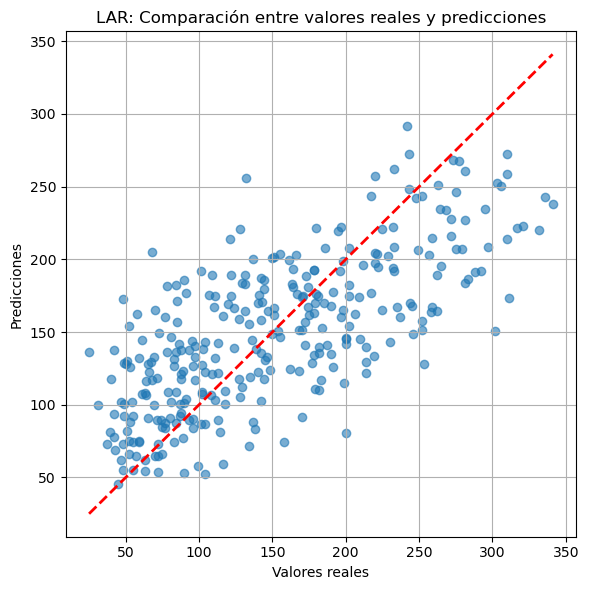

In [658]:
# Ajustar el modelo LassoLarsCV con validación cruzada
lar_cv = LassoLarsCV(cv=5, max_iter=10000)
lar_cv.fit(X_train, y_train)

# Mostrar el mejor alpha encontrado
print(f"Mejor alpha encontrado: {lar_cv.alpha_}")

# Crear un DataFrame con coeficientes y ordenarlos
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lar_cv.coef_
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("\nCoeficientes del mejor modelo (LAR):")
print(coef_df.head(10))  # Top 10 características más relevantes

# Hacer predicciones en los datos de entrenamiento
y_pred = lar_cv.predict(X_train)

# Calcular métricas de rendimiento
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"\nMSE en entrenamiento: {mse:.4f}")
print(f"R² en entrenamiento: {r2:.4f}")

# Visualización de predicciones vs valores reales
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('LAR: Comparación entre valores reales y predicciones')
plt.grid(True)
plt.tight_layout()
plt.show()

In [659]:
# Definir el grid de valores para alpha (lambda)
param_grid = {
    'alpha': np.logspace(-6, 6, 13)  # Diferentes valores de alpha
}

# Crear un scorer basado en MSE (menor es mejor)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Configurar el GridSearchCV con LassoLars
grid_search = GridSearchCV(
    estimator=LassoLars(max_iter=10000),  # Aumentamos max_iter para evitar warnings de convergencia
    param_grid=param_grid,
    cv=5,  # Validación cruzada con 5 pliegues
    scoring=mse_scorer,
    return_train_score=True
)

# Ajustar el modelo en el conjunto combinado (ya escalado)
grid_search.fit(X_combined, y_combined)

# Obtener el mejor modelo encontrado
best_model = grid_search.best_estimator_

# Extraer resultados del grid_search
results = grid_search.cv_results_

# Crear un DataFrame con los resultados de la validación cruzada
results_df = pd.DataFrame({
    'Alpha (lambda)': results['param_alpha'],
    'Mean Val Score (MSE)': -results['mean_test_score'],
    'Std Val Score': results['std_test_score'],
    'Mean Train Score (MSE)': -results['mean_train_score'],
    'Std Train Score': results['std_train_score'],
    'Rank Val Score': results['rank_test_score']
})

# Ordenar los resultados por la puntuación de validación (MSE)
results_df = results_df.sort_values(by='Rank Val Score')

# Obtener los coeficientes del mejor modelo LAR
coefficients = best_model.coef_

# Crear un DataFrame con los nombres de las características y sus coeficientes
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
})

# Ordenar los coeficientes por su valor absoluto
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar los coeficientes ordenados
print(f"\nCoeficientes del mejor modelo LAR (alpha = {best_model.alpha}):")
print(coef_df)



Coeficientes del mejor modelo LAR (alpha = 0.1):
  Feature  Coefficient  Abs_Coefficient
8      s5   505.668423       505.668423
2     bmi   500.856350       500.856350
3      bp   278.757074       278.757074
6      s3  -215.319714       215.319714
1     sex  -131.710392       131.710392
9      s6    44.819449        44.819449
4      s1   -20.080974        20.080974
0     age     0.000000         0.000000
5      s2     0.000000         0.000000
7      s4     0.000000         0.000000


In [660]:
print("\nResultados de la búsqueda con validación cruzada (Lasso LAR):")
results_df


Resultados de la búsqueda con validación cruzada (Lasso LAR):


,Alpha (lambda),Mean Val Score (MSE),Std Val Score,Mean Train Score (MSE),Std Train Score,Rank Val Score
5,0.1,3059.160767,515.199939,2891.854271,127.532180,1
4,0.01,3062.184650,512.173733,2849.426037,118.053711,2
3,0.001,3063.253269,495.465047,2842.562487,117.370094,3
2,0.0001,3063.991519,493.124275,2842.403241,117.343326,4
1,0.00001,3064.080825,492.892568,2842.401648,117.343058,5
0,0.000001,3064.089911,492.869422,2842.401632,117.343056,6
6,1.0,3863.727956,626.714733,3773.995176,128.044192,7
7,10.0,6103.621424,759.265556,6039.167685,195.506346,8
8,100.0,6103.621424,759.265556,6039.167685,195.506346,8
9,1000.0,6103.621424,759.265556,6039.167685,195.506346,8


### Incremental Forward Stagewise Regression

In [661]:
def forward_stagewise_incremental(X, y, epsilon=1e-3, max_iter=1000, tol=1e-6):

    # 1. Estandarizar predictores
    #scaler = StandardScaler()
    #X_std = scaler.fit_transform(X)

    # Inicializar
    n_samples, n_features = X.shape
    beta = np.zeros(n_features)
    r = y.copy()

    for _ in range(max_iter):
        # 2. Correlaciones con el residuo
        correlations = X.T @ r

        # Condición de parada
        max_corr = np.max(np.abs(correlations))
        if max_corr < tol:
            break

        # 3. Identificar el predictor más correlacionado
        j = np.argmax(np.abs(correlations))
        delta = epsilon * np.sign(correlations[j])

        # 4. Actualizar coeficiente y residuo
        beta[j] += delta
        r -= delta * X[:, j]

    return beta

beta_fs = forward_stagewise_incremental(X, y, epsilon=1e-2, max_iter=100000)

# 3. Mostrar resultados
coef_df = pd.DataFrame({
    'Predictores': X.columns,
    'Coeficientes_FSε': beta_fs
}).sort_values(by='Coeficientes_FSε', key=np.abs, ascending=False)

print(coef_df)


C:\Users\Usuario\AppData\Local\Temp\ipykernel_5444\484105970.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta = epsilon * np.sign(correlations[j])


InvalidIndexError: (slice(None, None, None), 2)

### Selector de Dantzig
Aunque no existen implementaciones estándar del Selector de Dantzig en bibliotecas comunes de Python como scikit-learn, es posible resolver este problema utilizando bibliotecas de optimización convexa como cvxpy.

In [ ]:
import cvxpy as cp

# Definir variables
n, p = X_train.shape
beta = cp.Variable(p)
lambda_param = 0.1  # Este valor puede ajustarse según sea necesario

# Definir el problema de optimización
objective = cp.Minimize(cp.norm1(beta))
constraints = [cp.norm_inf(X_train.T @ (y_train - X_train @ beta)) <= lambda_param]
problem = cp.Problem(objective, constraints)

# Resolver el problema
problem.solve()

# Mostrar los coeficientes estimados

# 3. Mostrar resultados
coef_df = pd.DataFrame({
    'Predictores': X.columns,
    'Coeficientes': beta.value
}).sort_values(by='Coeficientes', key=np.abs, ascending=False)

print(coef_df)


IndexError: tuple index out of range

### Grouped LASSO

In [ ]:
# Suponiendo que X_train_scaled y y_train ya están definidos

groups = np.array([0]*4 + [1]*6)

# Inicializar el modelo Group Lasso
model = GroupLasso(
    groups=groups,
    group_reg=0.1,  # Regularización a nivel de grupo
    l1_reg=0.01,    # Regularización L1 individual
    scale_reg='group_size',  # Escalar la regularización según el tamaño del grupo
    subsampling_scheme=1,
    supress_warning=True,
    fit_intercept=True
)

# Ajustar el modelo a los datos
model.fit(X_train, y_train)

# Obtener los coeficientes estimados
coeficientes = model.coef_

# Asegurarse de que los coeficientes sean unidimensionales
coeficientes = coeficientes.flatten()

# Crear un DataFrame para visualizar los coeficientes
coef_df = pd.DataFrame({
    'Característica': X.columns,
    'Coeficiente': coeficientes
})

# Ordenar por el valor absoluto de los coeficientes
coef_df['Valor absoluto'] = coef_df['Coeficiente'].abs()
coef_df = coef_df.sort_values(by='Valor absoluto', ascending=False)

print(coef_df)


  Característica  Coeficiente  Valor absoluto
8             s5     2.732391        2.732391
2            bmi     2.447235        2.447235
3             bp     2.031396        2.031396
7             s4     1.956187        1.956187
6             s3    -1.886281        1.886281
9             s6     1.732418        1.732418
4             s1     1.042384        1.042384
0            age     0.847187        0.847187
5             s2     0.822437        0.822437
1            sex     0.222775        0.222775


c:\Users\Usuario\Documents\Python Scripts\Lib\site-packages\group_lasso\_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(


# Reducción de Dimensión

### Regresión de Componentes Principales

PCA es sensible a la escala de los datos, por lo tanto, es recomendable escalar las características antes de aplicar PCA.

In [ ]:
# Crear el modelo PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Ver la cantidad de varianza explicada por cada componente principal
print("Varianza explicada por componente:", pca.explained_variance_ratio_)

Varianza explicada por componente: [0.40242108 0.14923197]


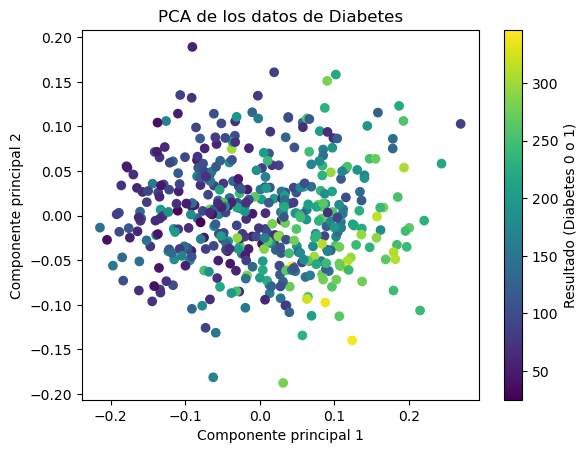

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('PCA de los datos de Diabetes')
plt.colorbar(label='Resultado (Diabetes 0 o 1)')
plt.show()

In [ ]:
# Crear el modelo de regresión lineal
model = LinearRegression()

# Ajustar el modelo a los datos de entrenamiento
model.fit(X_train, y_train)

# Hacer predicciones sobre los datos de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
print(f'Error cuadrático medio (MSE): {mse}')

Error cuadrático medio (MSE): 2422.423530492576


In [ ]:
# Crear un pipeline con PCA y regresión lineal
pca = PCA()
model = LinearRegression()

pipeline = Pipeline(steps=[
    ('pca', pca),
    ('regressor', model)
])


In [ ]:
# Definir los parámetros a probar
param_grid = {
    'pca__n_components': list(range(1, X.shape[1] + 1))  # Probar 1 a 10 componentes principales
}

In [ ]:
# Crear el objeto GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Ajustar el modelo con los datos
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros encontrados
print(f"Mejor número de componentes: {grid_search.best_params_['pca__n_components']}")

# Obtener el modelo final con los mejores parámetros
best_model = grid_search.best_estimator_

Mejor número de componentes: 8


In [ ]:
# Ajustar el mejor modelo con los datos de entrenamiento
best_model.fit(X_train, y_train)

# Realizar predicciones sobre los datos de prueba
y_pred = best_model.predict(X_val)

# Evaluar el modelo
mse = mean_squared_error(y_val, y_pred)
print(f"Error cuadrático medio (MSE) con el mejor número de componentes: {mse}")


Error cuadrático medio (MSE) con el mejor número de componentes: 3533.9157584056197


### PLS

In [ ]:
pls = PLSRegression(n_components=2, scale=True)
pls.fit(X_train, y_train)

PLSRegression()

In [ ]:
param_grid = {'n_components': range(1, 11)}
grid = GridSearchCV(pls, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=PLSRegression(),
             param_grid={'n_components': range(1, 11)},
             scoring='neg_mean_squared_error')